<a id='top'></a>

# Audio-Features - Genre Prediction (Classification)

Analysis of Billboard Hot-100 Data and Spotify Audio Features



<a id='toc'></a>

# Table of Contents

1. [Introduction](#intro)
2. [Notes](#notes)
3. [Data Processing](#data)
4. [Best Model Summary](#best)
5. [Model Comparisons](#comparisons)
6. [Visualizations](#visual)
7. [General Procedure](#general)
    1. [Grid Search](#grid)
        1. [Example 1](#grid1)
        2. [Example 2](#grid2)
        3. [Example 3](#grid3)
        4. [Example 4](#grid4)
    2. [Model Analysis](#analysis)
8. [All Models](#models)
    1. [k-Nearest Neightbors](#knn)
    2. [Logistic Regression](#logistic)
    3. [Ensemble Methods](#ensemble)
        1. [Random Forests](#forests)
        2. [AdaBoost](#ada)
        3. [Gradient Boosting](#gradient) ([summary](#gbc_summary))
    4. [SVM (SVC)](#svc)
9. [Miscellaneous Tests](#misc)


<a id='intro'></a>

# Introduction
([return to top](#top))

__Use data from Billboard charts (1960-2016) and associated Spotify audio features. This time we use several genre-specific Billboard charts, not the Hot-100: ['country', 'dance', 'latin', 'rnb', 'rock', 'pop']. The data are labeled by genre (categorical variable) and combined into a large dataset.__

__Goals include:__

-  __examining trends in audio features ('acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence') as a function of genre__ 
-  __using audio features for unknown songs to predict their genre classification.__

Originally I viewed pop as a distinct genre and wanted to include the pop Billboard charts alongside the other genres in this analysis. However, the pop 'genre' frequently features songs from other genres; indeed, xxx% of the songs in the pop charts were non-unique, i.e. appeared in another genre's charts. (There was also overlap, though much smaller, between many of the other genres, e.g. xxx% between 'country' and 'rock'.) So I decided to create two aggregrate datasets, one ('unique') containing only unique entries among all six genres and another ('unique_no_pop') containing unique entries among the five non-pop genres ('country', 'dance', 'latin', 'rnb', 'rock'). I expected that excluding the pop charts would result in clearer distinctions between genres and hence better genre predictions, but I wanted to analyze both datasets to make sure this intuition was correct.


Notes:

-  Care must be taken to handle the following categorical variables properly: ('key', 'mode', 'tempo', 'time_signature'). All other variables ('acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness, 'loudness', 'speechiness', 'tempo', 'valence') are continuous.

<a id='notes'></a>

# Notes
([return to top](#top))

-  Whittle data down to uniques only (i.e. tracks in each genre that are not in any other genre list), for better segmentation. 'df_unique' will include all genres of interest (['country', 'dance', 'latin', 'rnb', 'rock', 'pop']) (only excluding the 'all' dataframe), while 'df_unique_no_pop' excludes 'pop' in addition to 'all'.
-  Use "\_ranks" for rank (score) regression.
-  Use "\_unique" for genre classification.

### *To-do List:*

__BILLBOARD__

__IMPORTANT: Find important features by examining fitted models. (correlations)__






Summary statistics and histograms/scatterplots. PCA (?) and visualization. Use 2014-Labs 2,3,6,7 for help with exploratory data analysis then linear regression (billboard RANK). HW2,3,4 have info on linear regression; HW3 has an example of kNN; HW5 introduces classification methods such as random forests, decision trees, and SVM.

Goals: try out many methods at least once. [linear regression, logistic regression, random forests (bootstrapping?), decision trees, kNN, SVM]

Project endpoints: short articles and visualizations to suffice as "preliminary analysis" for Data Incubator.

__AUDICUS__

Re-acquaint with the datasets and models, then try to improve classification accuracy above 50% (at least). Then summarize and write-up the results.

Loose ends: finish NgML, refamiliarize with deep learning (UFLDL and CS231n)
Other topics: see fellowship guides (Data Incubator, Galvanize, Insight) and my bookmarks, but this should at least include: [probability/stats (incl. t-tests), machine learning, data scraping/engineering, CS algorithms]


(Feel free to add additional courses and descriptions of covered concepts.)

*CS109a*

HW2 - linear regression
HW3 - linear regression, k-NN
HW4 - linear regression
HW5 - classification (random forests, decision trees, SVM)

Lab2 - exploratory data analysis
Lab3 - exploratory data analysis
Lab4 - data scraping
Lab5 - data scraping
Lab6 - linear regression
Lab7 - linear regression


*CS231n*


*NgML*


*SQL*


*Algorithms*

__Approaches:__
    
-  kNN
-  Random forests (used basic classifier, need to try [more appropriate variations](http://scikit-learn.org/stable/modules/ensemble.html))
-  SVM (see [link](http://scikit-learn.org/stable/modules/svm.html#classification))

<a id='data'></a>

# Data Processing
([return to top](#top))

In [1]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import csv as csv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
import datetime
import requests
from bs4 import BeautifulSoup


In [2]:
chart_list = ['country', 'dance', 'latin', 'rnb', 'rock', 'pop', 'all']

#### Read pickled datasets and create pandas dataframes.

- Pickled dataset (unique\_no\_pop) contains unique entries among the following genres: `['country', 'dance', 'latin', 'rnb', 'rock']`.
- Create one-hot encodings for the `key` and `time_signature` features, which are actually categorical variables rather
- For genre classification, let's simplify things by using only the numeric features, i.e. remove `key` and `time_signature` altogether. This smaller dataframe is called `df_subset`.

In [3]:
df = pd.read_pickle('./data/pickle/unique-no-pop/unique_no_pop.pkl')
df['genre'] = df['genre'].astype('category')
genre_list = df.genre.cat.categories
print("Genre categories:")
print(genre_list)

df['code'] = df['genre'].cat.codes
df = df.reset_index().drop(['index', 'genre'], axis=1)
df_orig = df
df = df[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
       'time_signature', 'valence', 'code']].dropna(axis=0, how='any').apply(pd.to_numeric)
df = df.dropna()
df = df[~df.isin(['NaN']).any(axis=1)].apply(pd.to_numeric)

cols_to_transform = ['key', 'mode', 'time_signature']
df = pd.get_dummies(df, columns=cols_to_transform)

# Comment out the next line to include `time_signature` and `key` one-hot features.
df = df[['code', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
               'liveness', 'loudness', 'speechiness', 'tempo', 'valence']]
X = df.drop('code', axis=1)
y = np.ravel(df[['code']])

genre_feature_names = np.asarray(df.columns)
genre_index = np.argwhere(genre_feature_names=='code')
genre_feature_names = np.delete(genre_feature_names, genre_index)
print("Features list:")
print(genre_feature_names)

df.head()

Genre categories:
Index([u'country', u'dance', u'latin', u'rnb', u'rock'], dtype='object')
Features list:
['acousticness' 'danceability' 'duration_ms' 'energy' 'instrumentalness'
 'liveness' 'loudness' 'speechiness' 'tempo' 'valence']


,code,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0,0.0189,0.464,208960,0.945,0.0,0.0575,-3.342,0.0354,148.012,0.869
1,0,0.1020,0.553,243707,0.723,0.0,0.2120,-5.607,0.0453,157.998,0.462
2,0,0.4340,0.586,227427,0.399,0.0,0.1190,-9.338,0.0348,165.888,0.387
3,0,0.2680,0.421,228840,0.476,0.0,0.0816,-7.692,0.0298,169.784,0.281
4,0,0.3610,0.526,196960,0.661,0.0,0.0870,-3.828,0.0333,78.132,0.560


In [4]:
genre_dict = {}
for k in xrange(5):
    genre_dict[k] = genre_list[k]
    
print genre_dict

{0: 'country', 1: 'dance', 2: 'latin', 3: 'rnb', 4: 'rock'}


#### Check that the five genres are reasonably evenly distributed.

In [5]:
for k in xrange(5):
    print "Genre %i, %s: %s" % (k, genre_list[k], df[df['code'] == k].shape)

Genre 0, country: (5114, 11)
Genre 1, dance: (757, 11)
Genre 2, latin: (3140, 11)
Genre 3, rnb: (7857, 11)
Genre 4, rock: (1480, 11)


_Genre distribution is fairly uneven, but this should not be surprising: some of these charts (e.g. dance) did not exist until fairly recently, so they have fewer entries total._

Split data for cross-validation and try kNN with k-folds.

### Balance the dataset and create cross-validation split.

In [6]:
import sklearn
import sklearn.datasets
#import sklearn.cross_validation
import sklearn.model_selection
import sklearn.decomposition
import sklearn.grid_search
import sklearn.neighbors
import sklearn.metrics
from imblearn.over_sampling import RandomOverSampler


/home/austin/tensorflow/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/austin/tensorflow/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [7]:
ros = RandomOverSampler(random_state=24)
X_resampled, y_resampled = ros.fit_sample(X, y)

In [8]:
for k in xrange(5):
    print "Genre %i, %s: %s" % (k, genre_list[k], sum(y_resampled == k))

Genre 0, country: 7857
Genre 1, dance: 7857
Genre 2, latin: 7857
Genre 3, rnb: 7857
Genre 4, rock: 7857


Split the data into a train and a test set using the [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) function.

In [9]:
# put test data aside
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_resampled, y_resampled, test_size=0.1, random_state=42)

print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(35356, 10)
(3929, 10)
(35356,)
(3929,)


#### Normalize data using StandardScaler.

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  # apply same transformation to test data
X_scaled = scaler.transform(X)

Examine the data further by looking at the projections to the first two principal components of the data. Use the [`TruncatedSVD`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) function for this purpose, and create a scatter plot. Use the colors on the scatter plot to represent the different classes in the target data. 

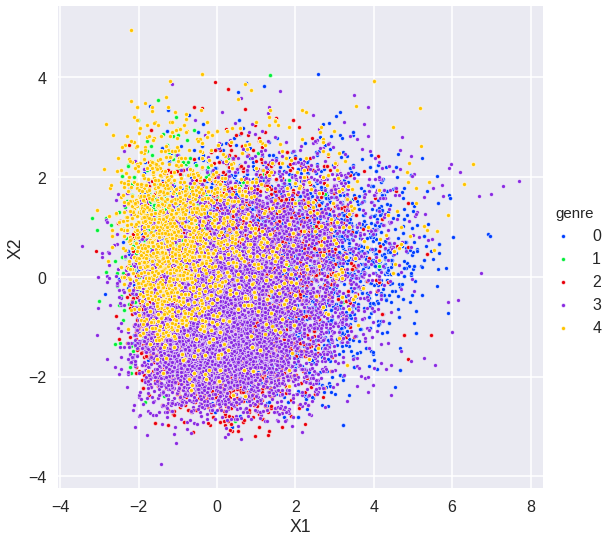

In [11]:
# make a scatter plot of the first two SVD components in two dimensions
svd = sklearn.decomposition.TruncatedSVD(n_components=2)
X_train_centered = X_train - np.mean(X_train, axis=0)
X_2d = svd.fit_transform(X_train_centered)

df_sns = pd.DataFrame(columns=('X1', 'X2', 'genre'))
df_sns['X1'] = X_2d[:,0]
df_sns['X2'] = X_2d[:,1]
df_sns['genre'] = y_train

#sns.set_context("paper")
#sns.set_context("notebook")
#sns.set_context("talk")
sns.set_context("poster")
sns.pairplot(x_vars=["X1"], y_vars=["X2"], data=df_sns, hue="genre", markers='o', 
             palette='bright', size=8, plot_kws={"s": 15, "alpha": 1})

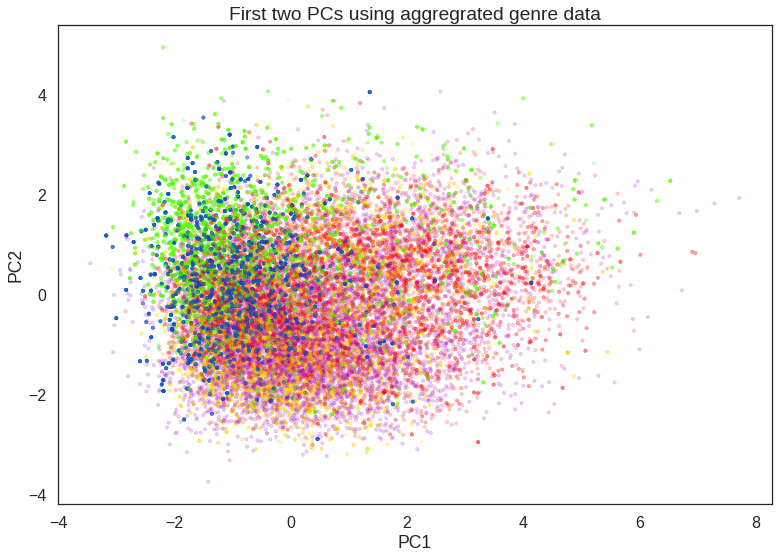

In [12]:
### Your code here ###

# make a scatter plot of the data in two dimensions
svd = sklearn.decomposition.TruncatedSVD(n_components=2)
X_train_centered = X_train - np.mean(X_train, axis=0)
X_2d = svd.fit_transform(X_train_centered)

sns.set_style('white')
colors = {0:'red', 1:'purple', 2:'green', 3:'black', 4:'blue'}


plt.scatter(X_2d[:,0], X_2d[:,1], c=y_train, s=12, cmap=plt.cm.prism, alpha=0.2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First two PCs using aggregrated genre data')
plt.show()

#### Results summary:

In [ ]:
# classifier_list = ['knn', 'lr', 'rfc', 'abc', 'gbc', 'svc']
# columns = ['train_acc', 'test_acc', 'p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'r_0', 'r_1', 'r_2', 'r_3', 'r_4', 'f']
# results_dict = {}
# for classifier in classifier_list:
#     results_dict[classifier] = [0.0] * 13
# print results_dict

In [ ]:
# results_df = pd.DataFrame.from_items(results_dict.items(), 
#                             orient='index', 
#                             columns=columns)
# results_df.head()

In [36]:
# results_df.head()

,train_acc,test_acc,p_0,p_1,p_2,p_3,p_4,r_0,r_1,r_2,r_3,r_4,f
knn,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
abc,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
gbc,0.997568,0.913464,0.858,0.983,0.875,0.889,0.959,0.872,1.0,0.931,0.759,0.997,0.912
svc,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
rfc,0.999972,0.923390,0.846,0.976,0.915,0.872,0.973,0.872,1.0,0.926,0.787,0.997,0.917


In [37]:
results_df.to_csv('results.csv')

In [38]:
results_df = pd.read_csv('results.csv', index_col=0)
results_df.head()

,train_acc,test_acc,p_0,p_1,p_2,p_3,p_4,r_0,r_1,r_2,r_3,r_4,f
knn,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
abc,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
gbc,0.997568,0.913464,0.858,0.983,0.875,0.889,0.959,0.872,1.0,0.931,0.759,0.997,0.912
svc,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
rfc,0.999972,0.923390,0.846,0.976,0.915,0.872,0.973,0.872,1.0,0.926,0.787,0.997,0.917


<a id='best'></a>

# Best Model Summary
([return to top](#top))

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# best = GradientBoostingClassifier(learning_rate=0.1, n_estimators=250, min_samples_split=500, 
#                                    min_samples_leaf=50, max_depth=8, 
#                                    max_features='sqrt', subsample=0.8, 
#                                    random_state=10)

best = GradientBoostingClassifier(learning_rate=0.01, 
                                  n_estimators=7000,
                                    min_samples_split=129,
                                    min_samples_leaf=61,
                                    max_depth=6,
                                    max_features=7,
                                    subsample=0.85,
                                    random_state=42)


best.fit(X_train, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=6,
              max_features=7, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=61, min_samples_split=129,
              min_weight_fraction_leaf=0.0, n_estimators=7000,
              presort='auto', random_state=42, subsample=0.85, verbose=0,
              warm_start=False)

In [26]:
score_train = best.score(X_train, y_train)
score_test = best.score(X_test, y_test)

print("------------")
print("training data score: ", best.score(X_train,y_train))
print("test data score: ", best.score(X_test,y_test))
print("------------")

results_df.loc[results_df['classifier'] == 'gbc'] = ['gbc', score_train, score_test]

------------
training data score:  0.9975675981445865
test data score:  0.9134639857470094
------------


In [27]:
y_pred = best.fit(X_train, y_train).predict(X_test)

In [45]:
from sklearn.metrics import classification_report

print('Classification report:')
print(classification_report(y_test, y_pred, digits=3))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

Classification report:
             precision    recall  f1-score   support

          0      0.858     0.872     0.865       783
          1      0.983     1.000     0.992       772
          2      0.875     0.931     0.902       823
          3      0.889     0.759     0.819       752
          4      0.959     0.997     0.978       799

avg / total      0.913     0.913     0.912      3929

Confusion matrix:
[[683   3  30  49  18]
 [  0 772   0   0   0]
 [ 30   4 766  22   1]
 [ 81   6  79 571  15]
 [  2   0   0   0 797]]


In [35]:
# columns = ['train_acc', 'test_acc', 'p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'r_0', 'r_1', 'r_2', 'r_3', 'r_4', 'f']

results_df.loc['gbc'] = [0.9975675981445865,
                         0.9134639857470094,
                         0.858,
                         0.983,
                         0.875,
                         0.889,
                         0.959,
                         0.872,
                         1.000,
                         0.931,
                         0.759,
                         0.997,
                         0.912]
results_df.head()

,train_acc,test_acc,p_0,p_1,p_2,p_3,p_4,r_0,r_1,r_2,r_3,r_4,f
knn,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
abc,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
gbc,0.997568,0.913464,0.858,0.983,0.875,0.889,0.959,0.872,1.0,0.931,0.759,0.997,0.912
svc,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
rfc,0.999972,0.923390,0.846,0.976,0.915,0.872,0.973,0.872,1.0,0.926,0.787,0.997,0.917


In [28]:
from sklearn.metrics import confusion_matrix

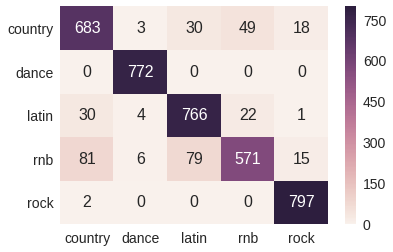

In [29]:
cnf_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cnf_matrix, index = [i for i in genre_list],
                     columns = [i for i in genre_list])
plt.figure(figsize=(6,4))
sns.set(font_scale=1.4)                                           # label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')   # font size
plt.savefig('gbc_best_confusion_A.png', bbox_inches='tight')

Confusion matrix, without normalization
[[683   3  30  49  18]
 [  0 772   0   0   0]
 [ 30   4 766  22   1]
 [ 81   6  79 571  15]
 [  2   0   0   0 797]]
Normalized confusion matrix
[[0.87 0.   0.04 0.06 0.02]
 [0.   1.   0.   0.   0.  ]
 [0.04 0.   0.93 0.03 0.  ]
 [0.11 0.01 0.11 0.76 0.02]
 [0.   0.   0.   0.   1.  ]]


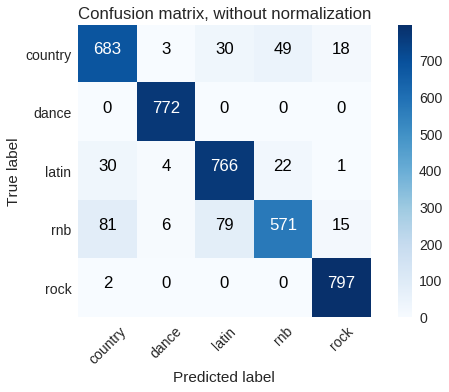

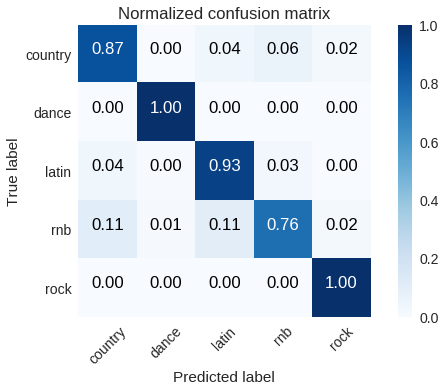

In [32]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=genre_list,
                      title='Confusion matrix, without normalization')
plt.grid('off')
plt.savefig('gbc_best_confusion_B.png', bbox_inches='tight')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=genre_list, normalize=True,
                      title='Normalized confusion matrix')
plt.grid('off')
plt.savefig('gbc_best_confusion_C.png', bbox_inches='tight')

### Feature Importances for Best Classifier

Max feature importance: 0.128890


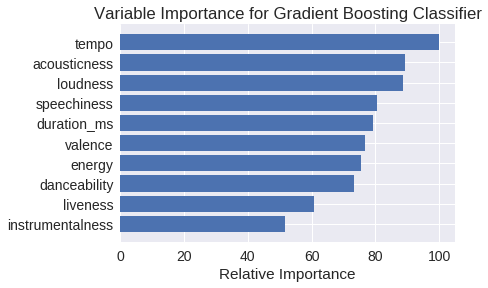

In [38]:
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error


# #############################################################################
# Plot feature importance
feature_importance = best.feature_importances_
# make importances relative to max importance
print "Max feature importance: %f" % feature_importance.max()
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance).astype(int)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(6,4))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, genre_feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance for Gradient Boosting Classifier')
plt.show()
plt.savefig('gbc_gs3_features_A.png', bbox_inches='tight')

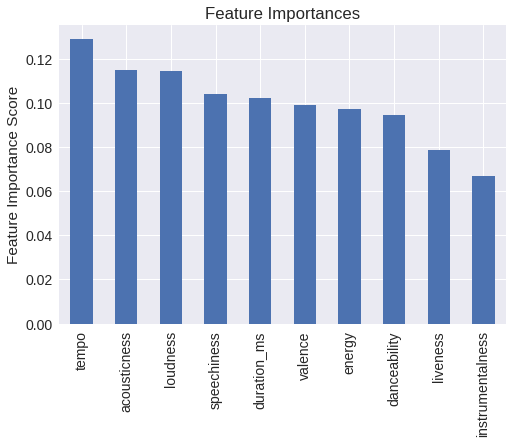

In [36]:
feat_imp = pd.Series(best.feature_importances_, genre_feature_names).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.savefig('gbc_gs3_features_B.png', bbox_inches='tight')

#### Precision/recall:

In [45]:
from sklearn.metrics import classification_report

print('Classification report:')
print(classification_report(y_test, y_pred, digits=3))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

Classification report:
             precision    recall  f1-score   support

          0      0.858     0.872     0.865       783
          1      0.983     1.000     0.992       772
          2      0.875     0.931     0.902       823
          3      0.889     0.759     0.819       752
          4      0.959     0.997     0.978       799

avg / total      0.913     0.913     0.912      3929

Confusion matrix:
[[683   3  30  49  18]
 [  0 772   0   0   0]
 [ 30   4 766  22   1]
 [ 81   6  79 571  15]
 [  2   0   0   0 797]]


<a id='comparisons'></a>

# Model Comparisons
([return to top](#top))

Create a dataframe of scores from all models

In [ ]:
score_train = best.score(X_train, y_train)
score_test = best.score(X_test, y_test)

print("------------")
print("training data score: ", best.score(X_train,y_train))
print("test data score: ", best.score(X_test,y_test))
print("------------")

results_df.loc[results_df['classifier'] == 'gbc'] = ['gbc', score_train, score_test]

Other ways of adding entries to dataframe:

In [82]:
results_df.loc[results_df.shape[0]] = ['gbc', 0.500, 0.250]

In [83]:
results_df.loc[results_df['classifier'] == 'gbc'] = ['gbc', 3, 4]

In [88]:
results_df.head()

In [90]:
results_df.loc['knn']

train_accuracy    0.0
test_accuracy     0.0
Name: knn, dtype: float64

In [97]:
results_df.loc[results_df.index == 'gbc', 'test_accuracy'] = 8.0

<a id='visual'></a>

# Data Visualizations
([return to top](#top))

#### Best Model Parameters

In [19]:
knn_best_params = {'n_neighbors': 20}
lr_best_params  = {}
rfc_best_params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
                   'learning_rate': 0.01, 'loss': 'ls'}
abc_best_params = {'learning_rate': 0.316, 'n_estimators': 250}
gbc_best_params = {'learning_rate': 0.1, 'n_estimators': 108}
svc_best_params = {'C': 2.31}




In [12]:
df.groupby('code').count()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,key_8,key_9,key_10,key_11,mode_0,mode_1,time_signature_1,time_signature_3,time_signature_4,time_signature_5
code,,,,,,,,,,,,,,,,,,,,,
0,5114,5114,5114,5114,5114,5114,5114,5114,5114,5114,...,5114,5114,5114,5114,5114,5114,5114,5114,5114,5114
1,757,757,757,757,757,757,757,757,757,757,...,757,757,757,757,757,757,757,757,757,757
2,3140,3140,3140,3140,3140,3140,3140,3140,3140,3140,...,3140,3140,3140,3140,3140,3140,3140,3140,3140,3140
3,7857,7857,7857,7857,7857,7857,7857,7857,7857,7857,...,7857,7857,7857,7857,7857,7857,7857,7857,7857,7857
4,1480,1480,1480,1480,1480,1480,1480,1480,1480,1480,...,1480,1480,1480,1480,1480,1480,1480,1480,1480,1480


In [13]:
genre_counts = df['code'].value_counts()
zed = pd.Series(range(5), genre_list)
genre_series = zed.map(genre_counts)
genre_series.sort_values(ascending=True, inplace=True)

In [14]:
genre_series

dance       757
rock       1480
latin      3140
country    5114
rnb        7857
dtype: int64

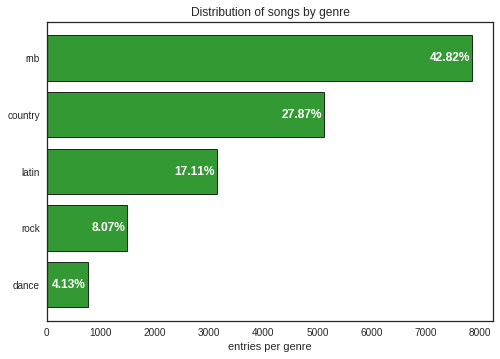

In [15]:
#Helper function to label the percentages 
def autolabel(rects, freqs):
    # attach some text labels
    for rect,f in zip(rects, freqs):
        width = int(rect.get_width())
        yloc = rect.get_y() + rect.get_height()/2.0

        plt.text(width*1.00 - 30.0, yloc, str(f)+"%", horizontalalignment='right',
            verticalalignment='center', color='w', weight='bold')

#Calculate class abundance and frequency
counts=[]
freqs=[]
for i in range(5):
    counts.append(genre_series[i])
    freqs.append(round(genre_series[i]*100.0/genre_series.sum(), 2))
    
rects = plt.barh(range(5), counts, align='center', alpha=0.8, color='g', edgecolor='k', linewidth=1);
plt.yticks(range(5), [genre_series.index[i] for i in range(5)]);
plt.xlabel('entries per genre');
plt.title('Distribution of songs by genre');
autolabel(rects, freqs)

In [16]:
yr_max = df_orig.groupby('code')['year'].max().reset_index()
yr_max.columns = ['code', 'max_year']

In [17]:
yr_min = df_orig.groupby('code')['year'].min().reset_index()
yr_min.columns = ['code', 'min_year']

In [18]:
yrs = yr_min.merge(yr_max)
yer = pd.Series(genre_list, index=yrs.index)
yrs.loc[:, 'genre'] = yer
year_ranges = yrs.set_index('genre')
year_ranges

,code,min_year,max_year
genre,,,
country,0,1962,2017
dance,1,2013,2017
latin,2,1986,2017
rnb,3,1962,2017
rock,4,2009,2017


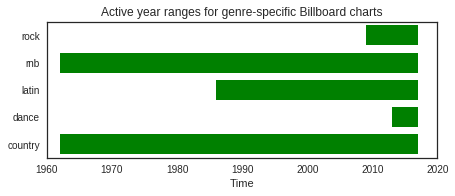

In [19]:
plt.rcParams["figure.figsize"] = [7.0, 2.5]

#Plot function
def timelines(y, xstart, xstop, color='b'):
    """Plot timelines at y from xstart to xstop with given color."""   
    plt.hlines(y, xstart, xstop, color, lw=20)
    #plt.vlines(xstart, y+0.03, y-0.03, color, lw=2)
    #plt.vlines(xstop, y+0.03, y-0.03, color, lw=2)

for i in range(len(year_ranges)):
    timelines(year_ranges.iloc[i]['code'], year_ranges.iloc[i]['min_year'], year_ranges.iloc[i]['max_year'], 'g')

#Setup the plot
ax = plt.gca()


plt.yticks(range(5), year_ranges.index)
plt.ylim(-0.5, 4.5)
plt.xlim(1960, 2020)
plt.xlabel('Time')
plt.title('Active year ranges for genre-specific Billboard charts')
plt.show()

### SVM

In [23]:
from sklearn import svm, grid_search
from sklearn.decomposition import PCA


#run svm analysis on PC transformed data with 5 dimensions
print "SVM with PCA, n_components"
pca=PCA(n_components=5, copy=True, whiten=False)
X_train_new=pca.fit_transform(X_train)
X_test_new=pca.transform(X_test)

svr = svm.SVC()
clf = grid_search.GridSearchCV(svr,{'C':[0.1,1,10, 100]})
clf.fit(X_train_new,y_train)

print "training data score: ", clf.score(X_train_new,y_train)
print "test data score: ", clf.score(X_test_new,y_test)
print "------------"


#run svm analysis on PC transformed data with 10 dimensions
print "SVM with PCA, n_components=10"
pca=PCA(n_components=10, copy=True, whiten=False)
X_train_new=pca.fit_transform(X_train)
X_test_new=pca.transform(X_test)

svr = svm.SVC()
clf = grid_search.GridSearchCV(svr,{'C':[0.1,1,10, 100]})
clf.fit(X_train_new,y_train)

print "training data score: ", clf.score(X_train_new,y_train)
print "test data score: ", clf.score(X_test_new,y_test)
print "------------"


#SVM without PCA
print "SVM without PCA (all features)"

svr = svm.SVC()
clf = grid_search.GridSearchCV(svr,{'C':[0.1,1,10,100]})
clf.fit(X_train,y_train)
print "training data score: ", clf.score(X_train,y_train)
print "test data score: ", clf.score(X_test,y_test)
print "------------"


SVM with PCA, n_components=10
training data score:  0.683744379343
test data score:  0.626702997275
------------
SVM with PCA, n_components
training data score:  0.616841531544
test data score:  0.589373297003
------------
SVM without PCA
training data score:  0.76999591225
test data score:  0.688555858311
------------


### AdaBoost/GradientBoosting

#### Improvement: sub in best parameters for Ada and Gradient models below

In [30]:
#helper function for calculating mean test data performance as well as best features
def mean_test_score_and_feature_importance(classifier, X, Y, num_trials):
    scores=[]
    feature_importances=[]
    for i in range(num_trials):
        X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, Y, test_size=0.25)
        clf = classifier.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
        if feature_importances:
            for i in range(len(feature_importances)):
                feature_importances[i] += clf.feature_importances_[i]*1.0/num_trials
        else:
            feature_importances=[u*1.0/num_trials for u in clf.feature_importances_]
            
    return scores, feature_importances

In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

ABC = AdaBoostClassifier(n_estimators=50)
scores = sklearn.cross_validation.cross_val_score(ABC, X_train, y_train, cv=5)

print "Adaboost"
print "CV mean score:", np.mean(scores)
#get mean test score and feature importances
scores, feature_importances_abc = mean_test_score_and_feature_importance(ABC, X_scaled, y, 20)       
print "test data mean score: " , np.mean(scores)

print "------------"


print "Gradient Boosting" 
GBC = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=50, subsample=1.0, min_samples_split=2, min_samples_leaf=1, max_depth=3, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False)
scores = sklearn.cross_validation.cross_val_score(GBC, X_train, y_train, cv=5)
print "CV mean score: ", np.mean(scores)
#get mean test score and feature importances
scores, feature_importances_gbc = mean_test_score_and_feature_importance(GBC, X_scaled, y, 20)       
print "test data mean score: " , np.mean(scores)

Adaboost
CV mean score: 0.616636685455
test data mean score:  0.625724874646
------------
Gradient Boosting
CV mean score:  0.6754320638
test data mean score:  0.679747111402


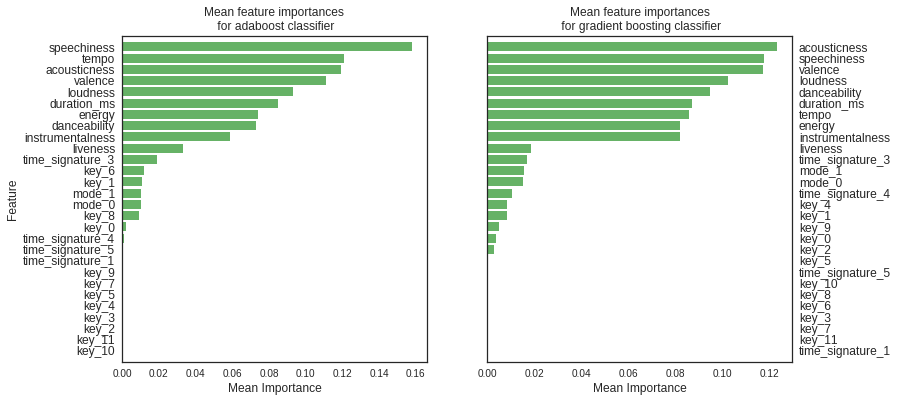

In [36]:
plt.figure(figsize=(12, 6))

plt.subplot('121')
#draw feature importance for adaboost
sorted_features2 = sorted(zip(feature_importances_abc, genre_feature_names))
importances2, params_sorted2 = zip(*sorted_features2)
plt.ylim([-1, len(genre_feature_names)])
plt.barh(range(len(genre_feature_names)), importances2, align='center', alpha=0.6, color='g')
plt.yticks(range(len(genre_feature_names)), params_sorted2, fontsize=12);
plt.ylabel('Feature', fontsize=12);
plt.xlabel('Mean Importance', fontsize=12);
plt.title('Mean feature importances\n for adaboost classifier');

#draw feature importance for gradientboost

plt.subplot('122')
sorted_features1 = sorted(zip(feature_importances_gbc, genre_feature_names))
importances1, params_sorted1 = zip(*sorted_features1)
plt.ylim([-1, len(genre_feature_names)])
plt.barh(range(len(genre_feature_names)), importances1, align='center', alpha=0.6, color='g')
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')

plt.yticks(range(len(genre_feature_names)), params_sorted1, fontsize=12);
plt.xlabel('Mean Importance', fontsize=12);
plt.title('Mean feature importances\n for gradient boosting classifier');

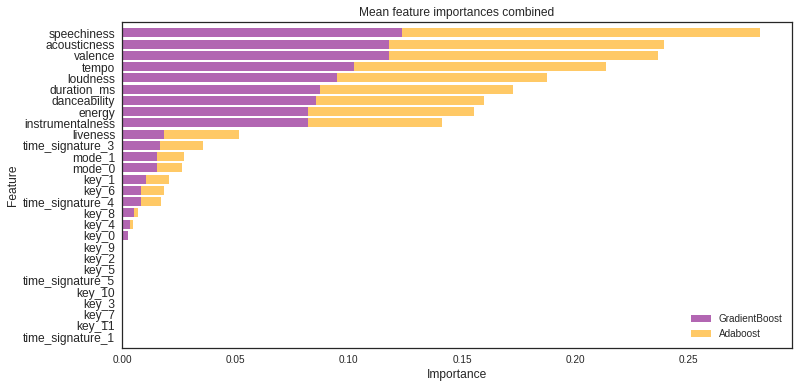

In [38]:
#combine the scores for sorting
combined_score = [c+d for c,d in zip(feature_importances_abc, feature_importances_gbc)]
sorted_features3 = sorted(zip(combined_score, genre_feature_names))
importances3, params_sorted3 = zip(*sorted_features3)
plt.figure(figsize=(12, 6))
p1 = plt.barh(range(len(genre_feature_names)), importances1, align='center', color='purple', 
            label='GradientBoost', alpha=0.6)
p2 = plt.barh(range(len(genre_feature_names)), importances2, align='center', color='orange', 
            left=importances1, label='Adaboost', alpha=0.6)
plt.ylim([-1, len(genre_feature_names)])
plt.yticks(range(len(genre_feature_names)), params_sorted3, fontsize=12);
plt.ylabel('Feature', fontsize=12);
plt.xlabel('Importance', fontsize=12);
plt.title('Mean feature importances combined');
plt.legend(loc=4);
plt.show()

<a id='general'></a>

# General Procedure (Model Sandbox)
([return to top](#top))

This is a general starting point for genre classification; modify as needed.

<a id='grid'></a>

### Grid Search
([return to top](#top))

<a id='grid1'></a>

### Method 1

http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py

([return to top](#top))

In [ ]:
print(__doc__)

import numpy as np

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# get some data
digits = load_digits()
X, y = digits.data, digits.target

# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

In [30]:
def computeTestScores(test_x, test_y, clf, cv):
    kf = sklearn.model_selection.KFold(n_splits=cv)

    scores = []
    for train, test in kf.split(test_x):
        test_data = test_x.iloc[test]
        test_labels = test_y[test]
        scores.append(sklearn.metrics.accuracy_score(test_labels, clf.predict(test_data)))
    return scores

In [31]:
## no measurement without standard deviation
scores = computeTestScores(test_x=X_test, test_y=y_test, clf=grid_search.best_estimator_, cv=5)
print('Test Scores:')
print('Mean: %f' % np.mean(scores))
print('Stdev: %f' % np.std(scores))

0.448554913295 0.0138806945595


<a id='grid2'></a>

### Method 2

http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

([return to top](#top))

In [ ]:
from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

<a id='grid3'></a>

### Method 3

http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html

([return to top](#top))

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

In [ ]:
X, y = make_hastie_10_2(n_samples=8000, random_state=42)

# The scorers can be either be one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_parameters_`` and
# ``gs.best_index_``
gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid={'min_samples_split': range(2, 403, 10)},
                  scoring=scoring, cv=5, refit='AUC')
gs.fit(X, y)
results = gs.cv_results_

In [ ]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_min_samples_split'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

<a id='grid4'></a>

### Method 4 (Old)

([return to top](#top))

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=200)
scores = cross_val_score(clf, X_train, y_train)
scores.mean()

0.61527499333376667

In [12]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

parameters = {'n_estimators': [100, 250], 'learning_rate': np.logspace(-1, 0, 3)}
abc = AdaBoostClassifier()
clf = GridSearchCV(abc, parameters, cv=10)
clf.fit(X_train, y_train)

# clf.cv_results_

{'mean_fit_time': array([ 1.50909872,  4.00532217,  1.93692365,  4.85483298,  1.9244854 ,
         4.93049982]),
 'mean_score_time': array([ 0.03504367,  0.11527872,  0.07348363,  0.18174574,  0.07320073,
         0.18260496]),
 'mean_test_score': array([ 0.60900668,  0.63530454,  0.64095926,  0.64627333,  0.62358632,
         0.61874915]),
 'mean_train_score': array([ 0.61157293,  0.63987676,  0.64551639,  0.65022482,  0.62972541,
         0.62536535]),
 'param_learning_rate': masked_array(data = [0.10000000000000001 0.10000000000000001 0.31622776601683794
  0.31622776601683794 1.0 1.0],
              mask = [False False False False False False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [100 250 100 250 100 250],
              mask = [False False False False False False],
        fill_value = ?),
 'params': ({'learning_rate': 0.10000000000000001, 'n_estimators': 100},
  {'learning_rate': 0.10000000000000001, 'n_estimators': 250},
  {'learning_rate': 0.316227

<a id='analysis'></a>

### Model Analysis
([return to top](#top))

In [13]:
clf.best_score_

0.64627333424172229

In [14]:
clf.best_estimator_.score(X_test, y_test)

0.66866485013623977

Max feature importance: 0.128000


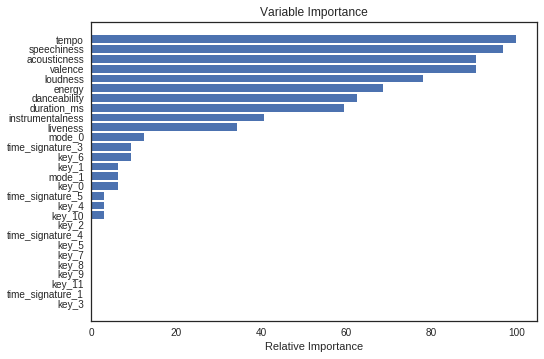

In [15]:
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# #############################################################################
# Get best classifier

clf_best = clf.best_estimator_

# #############################################################################
# Plot feature importance
feature_importance = clf_best.feature_importances_
# make importances relative to max importance
print "Max feature importance: %f" % feature_importance.max()
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance).astype(int)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, genre_feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [16]:
base_model = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,
                                        min_samples_leaf=50, max_depth=8,
                                        max_features='sqrt', subsample=0.8,
                                        random_state=42)

grid = {'n_estimators': range(60, 120, 6), 
              'learning_rate': np.linspace(0.05, 0.25, 5)}

gsearch = GridSearchCV(estimator=base_model, param_grid=grid, iid=False, cv=5)
gsearch.fit(X_train, y_train)

NameError: name 'GradientBoostingClassifier' is not defined

#### Learning Rate Plot

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                 max_depth=1, random_state=0)
lr_s = np.linspace(0.2, 2.0, 8)

scores = list()
scores_std = list()
for lr in lr_s:
    clf.learning_rate = lr
    this_scores = cross_val_score(clf, X_train, y_train, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

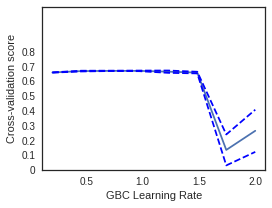

In [15]:
# Do the plotting
import matplotlib.pyplot as plt
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.plot(lr_s, scores)
plt.plot(lr_s, np.array(scores) + np.array(scores_std), 'b--')
plt.plot(lr_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('Cross-validation score')
plt.xlabel('GBC Learning Rate')
plt.ylim(0, 1.1)
plt.show()

#### Grid search (GBR)

In [30]:
#Choose all predictors except target & IDcols

X_values = X.values

param_test1 = {'n_estimators': range(60, 120, 6), 'learning_rate': np.linspace(0.05, 0.25, 5)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500, 
                                                               min_samples_leaf=50, max_depth=8, 
                                                               max_features='sqrt', subsample=0.8, 
                                                               random_state=10), 
                        param_grid = param_test1, iid=False, cv=5)
gsearch1.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=50,
              min_samples_split=500, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'n_estimators': [60, 66, 72, 78, 84, 90, 96, 102, 108, 114], 'learning_rate': array([ 0.05,  0.1 ,  0.15,  0.2 ,  0.25])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [31]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 3.93979998,  4.43119025,  5.15301385,  5.20699058,  5.44538364,
          5.83138981,  6.25754304,  6.5845572 ,  6.94223719,  7.31524377,
          3.84803872,  4.28114262,  4.62466521,  4.95243497,  5.46427579,
          6.19102321,  6.72262421,  7.06283937,  7.48646016,  7.87237997,
          4.21287785,  4.60623431,  4.99333882,  5.39104495,  5.79244151,
          6.17251358,  6.56301537,  6.91356626,  7.07322221,  7.45175543,
          4.00669227,  4.37090459,  4.74126039,  5.1137548 ,  5.48611112,
          5.85472703,  6.22852864,  6.60923333,  6.9892168 ,  7.49109697,
          4.06850576,  4.46947141,  4.86227694,  5.27298255,  5.32498178,
          5.57207141,  5.71946578,  6.07187281,  6.42155218,  6.77932854]),
  'mean_score_time': array([ 0.03399839,  0.03730221,  0.04067698,  0.04341426,  0.04652591,
          0.04955077,  0.05264597,  0.05570416,  0.05871964,  0.06174617,
          0.03339682,  0.03678961,  0.03944101,  0.04250078,  0.04594626,


<a id='models'></a>

## All Models
([return to top](#top))

<a id='knn'></a>

## $k$-Nearest Neighbors and Cross Validation 
([return to top](#top))

(From Harvard CS109a course materials)

In [46]:
k = np.arange(20) + 1

parameters = {'n_neighbors': k}
knn = sklearn.neighbors.KNeighborsClassifier()
clf = sklearn.grid_search.GridSearchCV(knn, parameters, cv=10)
clf.fit(X_train, y_train)

clf.grid_scores_

[mean: 0.87275, std: 0.00364, params: {'n_neighbors': 1},
 mean: 0.82894, std: 0.00199, params: {'n_neighbors': 2},
 mean: 0.79981, std: 0.00357, params: {'n_neighbors': 3},
 mean: 0.76954, std: 0.00566, params: {'n_neighbors': 4},
 mean: 0.75407, std: 0.00567, params: {'n_neighbors': 5},
 mean: 0.73382, std: 0.00629, params: {'n_neighbors': 6},
 mean: 0.72180, std: 0.00521, params: {'n_neighbors': 7},
 mean: 0.70545, std: 0.00672, params: {'n_neighbors': 8},
 mean: 0.69784, std: 0.00826, params: {'n_neighbors': 9},
 mean: 0.68565, std: 0.00984, params: {'n_neighbors': 10},
 mean: 0.67765, std: 0.01020, params: {'n_neighbors': 11},
 mean: 0.66690, std: 0.01015, params: {'n_neighbors': 12},
 mean: 0.66167, std: 0.00918, params: {'n_neighbors': 13},
 mean: 0.65417, std: 0.00924, params: {'n_neighbors': 14},
 mean: 0.65132, std: 0.00859, params: {'n_neighbors': 15},
 mean: 0.64609, std: 0.00696, params: {'n_neighbors': 16},
 mean: 0.64569, std: 0.00704, params: {'n_neighbors': 17},
 mean:

#### Problem 2(d)

Visualize the result by plotting the score results versus values for $k$. 

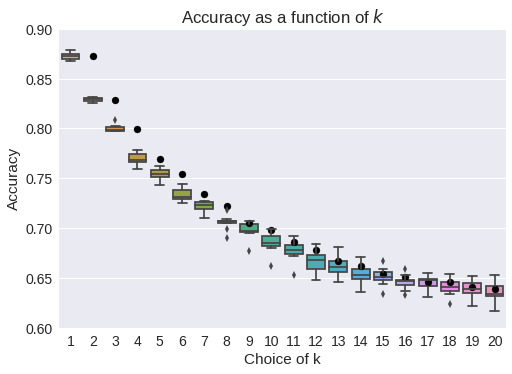

In [49]:
### Your code here ###
a = clf.grid_scores_
scores = [b.cv_validation_scores for b in a]
k_vals = [b.parameters['n_neighbors'] for b in a]

score_means = np.mean(scores, axis=1)

sns.boxplot(x=k_vals, y=scores)
plt.scatter(k, score_means, c='k', zorder=2)
plt.ylim(0.6, 0.9)
plt.title('Accuracy as a function of $k$')
plt.ylabel('Accuracy')
plt.xlabel('Choice of k')
plt.show()
plt.savefig('knn_gs_n_neighbors.png', bbox_inches='tight')

In [50]:
### Verify the grid search has indeed chosen the right parameter value for k. ###

clf.best_params_

{'n_neighbors': 1}

#### Test the performance of our tuned KNN classifier on the test set.

In [54]:
X_test.shape

(3929, 10)

In [55]:
def computeTestScores(test_x, test_y, clf, cv):
    kf = sklearn.model_selection.KFold(n_splits=cv)

    scores = []
    for train, test in kf.split(test_x):
        test_data = test_x[test, :]
        test_labels = test_y[test]
        scores.append(sklearn.metrics.accuracy_score(test_labels, clf.predict(test_data)))
    return scores

In [56]:
## no measurement without standard deviation
scores = computeTestScores(test_x=X_test, test_y=y_test, clf=clf.best_estimator_, cv=5)
print('Test Scores:')
print('Mean: %f' % np.mean(scores))
print('Stdev: %f' % np.std(scores))

Test Scores:
Mean: 0.878597
Stdev: 0.010429


- Decent performance, but we can probably do better with a more advanced model.

In [ ]:
best = clf.best_estimator_

print("------------")
print("training data score: ", best.score(X_train, y_train))
print("test data score: ", best.score(X_test, y_test))
print("------------")

# old: 0.9467700, 0.8785951

In [20]:
y_pred = best.fit(X_train, y_train).predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

print('Classification report:')
print(classification_report(y_test, y_pred, digits=3))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

In [ ]:
# columns = ['train_acc', 'test_acc', 'p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'r_0', 'r_1', 'r_2', 'r_3', 'r_4', 'f']

results_df.loc[results_df['classifier'] == 'knn'] = ['knn',
                                                     0.9999717162574951,
                                                     0.9233901756172054,
                                                     0.846,
                                                     0.976,
                                                     0.915,
                                                     0.872,
                                                     0.973,
                                                     0.872,
                                                     1.000,
                                                     0.926,
                                                     0.787,
                                                     0.997,
                                                     0.917]

<a id='logistic'></a>

## Logistic Regression
([return to top](#top))

In [ ]:
from sklearn.linear_model import LogisticRegression

C_range = np.logspace(-2, 10, 13)
param_grid = dict(C=C_range)
print(param_grid)

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_parameters_`` and
# ``gs.best_index_``
gs = GridSearchCV(LogisticRegression(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy', 
                  cv=5)
gs.fit(X, y)
results = gs.cv_results_

In [ ]:
plt.figure(figsize=(7, 7))
plt.title("GridSearchCV evaluating $C$ values for logistic regression",
          fontsize=16)

plt.xlabel("C")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_min_samples_split'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()
plt.savefig('lr_gs_c.png', bbox_inches='tight')

In [ ]:
print(__doc__)

import numpy as np

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

# get some data
digits = load_digits()
X, y = digits.data, digits.target

# build a classifier
clf = AdaBoostClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

<a id='ensemble'></a>

## Ensemble Methods
([return to top](#top))

-  RandomForestClassifier/ExtraTreesClassifier
-  AdaBoostClassifier
-  GradientBoostingClassifier
-  SVC/nuSVC/LinearSVC


<a id='forests'></a>

### Random Forests
([return to top](#top))

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
X_train.shape

(35356, 10)

In [16]:
from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

print(__doc__)

# Set the parameters by cross-validation
tuned_parameters = [{"n_estimators": [10, 20],
                     "max_depth": [None],
                     "max_features": [1, 3, 7, 10],
                     "min_samples_split": [2, 3, 10],
                     "min_samples_leaf": [1, 3, 10],
                     "bootstrap": [True, False],
                     "criterion": ["gini", "entropy"]}]

scores = ['precision', 'recall']
clfs = {}

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)
    
    clfs[score] = clf.best_estimator_

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 20, 'min_samples_split': 3, 'criterion': 'gini', 'max_features': 3, 'max_depth': None}

Grid scores on development set:

0.881 (+/-0.011) for {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 10, 'min_samples_split': 2, 'criterion': 'gini', 'max_features': 1, 'max_depth': None}
0.895 (+/-0.007) for {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 20, 'min_samples_split': 2, 'criterion': 'gini', 'max_features': 1, 'max_depth': None}
0.882 (+/-0.006) for {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 10, 'min_samples_split': 3, 'criterion': 'gini', 'max_features': 1, 'max_depth': None}
0.898 (+/-0.004) for {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 20, 'min_samples_split': 3, 'criterion': 'gini', 'max_features': 1, 'max_depth': None

Best parameters set found on development set:

{'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 20, 'min_samples_split': 3, 'criterion': 'entropy', 'max_features': 1, 'max_depth': None}

Grid scores on development set:

0.881 (+/-0.008) for {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 10, 'min_samples_split': 2, 'criterion': 'gini', 'max_features': 1, 'max_depth': None}
0.896 (+/-0.009) for {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 20, 'min_samples_split': 2, 'criterion': 'gini', 'max_features': 1, 'max_depth': None}
0.883 (+/-0.005) for {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 10, 'min_samples_split': 3, 'criterion': 'gini', 'max_features': 1, 'max_depth': None}
0.898 (+/-0.004) for {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 20, 'min_samples_split': 3, 'criterion': 'gini', 'max_features': 1, 'max_depth': None}
0.860 (+/-0.013) for {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 10, 'min_samples_spli

Best parameters set found on development set:

{'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 20, 'min_samples_split': 3, 'criterion': 'gini', 'max_features': 3, 'max_depth': None}

In [19]:
best = clfs['precision']

print("------------")
print("training data score: ", best.score(X_train, y_train))
print("test data score: ", best.score(X_test, y_test))
print("------------")

# old: 0.9467700, 0.8785951

------------
training data score:  0.9999717162574951
test data score:  0.9233901756172054
------------


In [20]:
y_pred = best.fit(X_train, y_train).predict(X_test)

In [27]:
from sklearn.metrics import classification_report

print('Classification report:')
print(classification_report(y_test, y_pred, digits=3))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

Classification report:
             precision    recall  f1-score   support

          0      0.846     0.872     0.859       783
          1      0.976     1.000     0.988       772
          2      0.915     0.926     0.920       823
          3      0.872     0.787     0.827       752
          4      0.973     0.997     0.985       799

avg / total      0.917     0.918     0.917      3929

Confusion matrix:
[[683   5  20  60  15]
 [  0 772   0   0   0]
 [ 28   4 762  27   2]
 [ 94  10  51 592   5]
 [  2   0   0   0 797]]


In [34]:
# columns = ['train_acc', 'test_acc', 'p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'r_0', 'r_1', 'r_2', 'r_3', 'r_4', 'f']

results_df.loc['rfc'] = [0.9999717162574951,
                         0.9233901756172054,
                         0.846,
                         0.976,
                         0.915,
                         0.872,
                         0.973,
                         0.872,
                         1.000,
                         0.926,
                         0.787,
                         0.997,
                         0.917]
results_df.head()

,train_acc,test_acc,p_0,p_1,p_2,p_3,p_4,r_0,r_1,r_2,r_3,r_4,f
knn,0.000000,0.00000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
abc,0.000000,0.00000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
gbc,0.000000,0.00000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
svc,0.000000,0.00000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
rfc,0.999972,0.92339,0.846,0.976,0.915,0.872,0.973,0.872,1.0,0.926,0.787,0.997,0.917


In [21]:
from sklearn.metrics import confusion_matrix

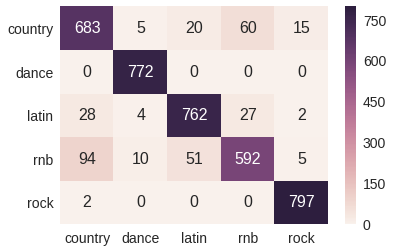

In [28]:
cnf_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cnf_matrix, index = [i for i in genre_list],
                     columns = [i for i in genre_list])
plt.figure(figsize=(6,4))
sns.set(font_scale=1.4)                                           # label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')   # font size
plt.savefig('rf_confusion_A.png', bbox_inches='tight')

Confusion matrix, without normalization
[[683   5  20  60  15]
 [  0 772   0   0   0]
 [ 28   4 762  27   2]
 [ 94  10  51 592   5]
 [  2   0   0   0 797]]
Normalized confusion matrix
[[0.87 0.01 0.03 0.08 0.02]
 [0.   1.   0.   0.   0.  ]
 [0.03 0.   0.93 0.03 0.  ]
 [0.12 0.01 0.07 0.79 0.01]
 [0.   0.   0.   0.   1.  ]]


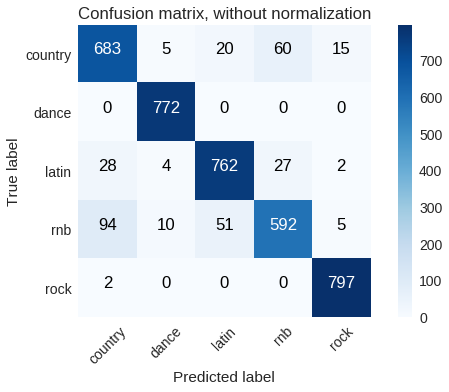

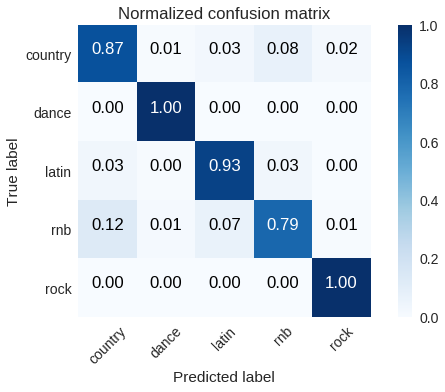

In [23]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=genre_list,
                      title='Confusion matrix, without normalization')
plt.grid('off')
plt.savefig('rf_best_confusion_B.png', bbox_inches='tight')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=genre_list, normalize=True,
                      title='Normalized confusion matrix')
plt.grid('off')
plt.savefig('rf_best_confusion_C.png', bbox_inches='tight')

### Feature Importances for Best Classifier

Max feature importance: 0.139293


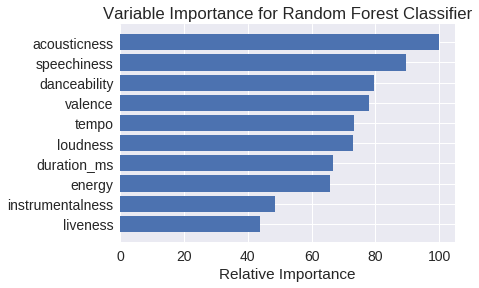

In [25]:
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error


# #############################################################################
# Plot feature importance
feature_importance = best.feature_importances_
# make importances relative to max importance
print("Max feature importance: %f" % feature_importance.max())
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance).astype(int)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(6,4))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, genre_feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance for Random Forest Classifier')
plt.show()
plt.savefig('rf_features_A.png', bbox_inches='tight')

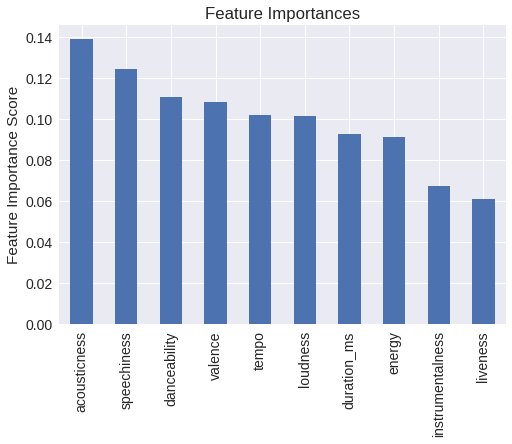

In [26]:
feat_imp = pd.Series(best.feature_importances_, genre_feature_names).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.savefig('rf_features_B.png', bbox_inches='tight')

#### Precision/recall:

In [27]:
from sklearn.metrics import classification_report

print('Classification report:')
print(classification_report(y_test, y_pred, digits=3))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

Classification report:
             precision    recall  f1-score   support

          0      0.846     0.872     0.859       783
          1      0.976     1.000     0.988       772
          2      0.915     0.926     0.920       823
          3      0.872     0.787     0.827       752
          4      0.973     0.997     0.985       799

avg / total      0.917     0.918     0.917      3929

Confusion matrix:
[[683   5  20  60  15]
 [  0 772   0   0   0]
 [ 28   4 762  27   2]
 [ 94  10  51 592   5]
 [  2   0   0   0 797]]


In [29]:
print(genre_list)

Index([u'country', u'dance', u'latin', u'rnb', u'rock'], dtype='object')


#### Old approach:

_Reference: CS109a 2014 | HW5_

Now let's try random forests (w/ cross-validation) for genre classification.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# your code here
scores = []
box = pd.DataFrame(columns=['ne', 'score'])

for ne in range(1,41):
    clf = RandomForestClassifier(n_estimators = ne)
    score_list = cross_val_score(clf, X_train, y_train, cv=10)
    for sc in score_list:
        box.loc[len(box)] = [ne, sc]
    scores.append(score_list)



In [78]:
scores[39].mean()

0.68796685303674621

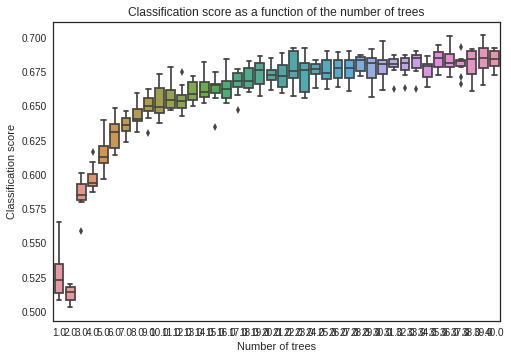

In [11]:
sns.boxplot(x="ne", y="score", data=box)
plt.xlabel('Number of trees')
plt.ylabel('Classification score')
plt.title('Classification score as a function of the number of trees')
plt.show()

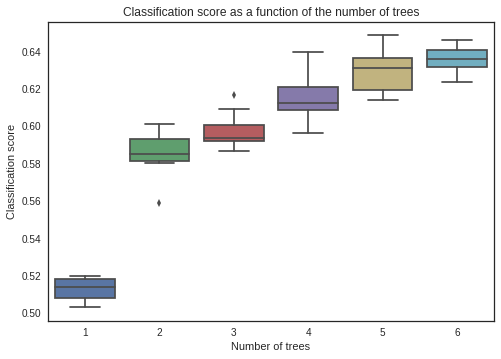

In [12]:
sns.boxplot(x=range(1,7), y=scores[1:7])
plt.xlabel('Number of trees')
plt.ylabel('Classification score')
plt.title('Classification score as a function of the number of trees')
plt.show()

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# your code here
scores = []
box = pd.DataFrame(columns=['ne', 'score'])

for ne in range(1,41):
    clf = RandomForestClassifier(n_estimators = ne)
    score_list = cross_val_score(clf, X_train, y_train, cv=10)
    for sc in score_list:
        box.loc[len(box)] = [ne, sc]
    scores.append(score_list)



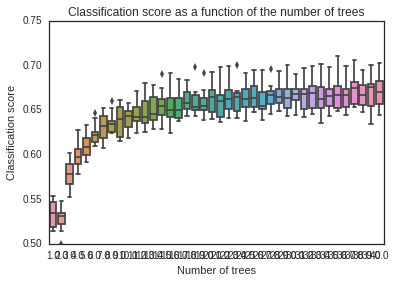

In [47]:
sns.boxplot(x="ne", y="score", data=box)
plt.xlabel('Number of trees')
plt.ylabel('Classification score')
plt.title('Classification score as a function of the number of trees')
plt.show()

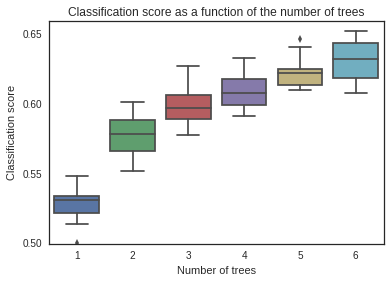

In [48]:
sns.boxplot(x=range(1,7), y=scores[1:7])
plt.xlabel('Number of trees')
plt.ylabel('Classification score')
plt.title('Classification score as a function of the number of trees')
plt.show()

We should still try RandomForestClassifier in tandem w/ sklearn's cross_val, but we can get back to that later...

##### "OOB Errors for Random Forests" - a scikit-learn example

/home/austin/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/austin/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


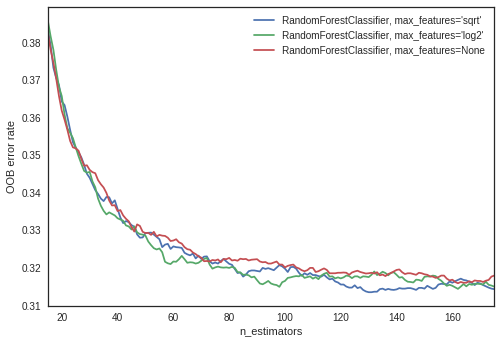

In [18]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

RANDOM_STATE = 123

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

Max feature importance: 0.141343


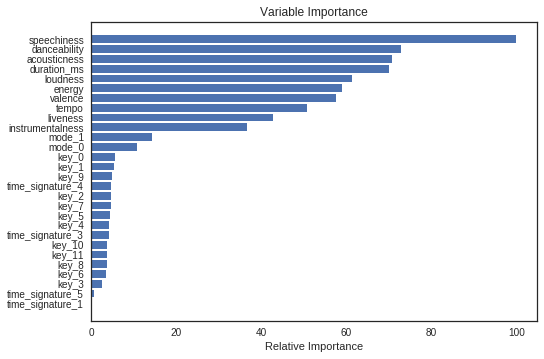

In [18]:
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = RandomForestClassifier(n_estimators=40)

clf.fit(X_train, y_train)


# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
print "Max feature importance: %f" % feature_importance.max()
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance).astype(int)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, genre_feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

<a id='ada'></a>

### AdaBoostClassifier
([return to top](#top))

In [ ]:
print(__doc__)

import numpy as np

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

# get some data
digits = load_digits()
X, y = digits.data, digits.target

# build a classifier
clf = AdaBoostClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

##### 7/26/17

-  RandomForestClassifier/ExtraTreesClassifier
-  AdaBoostClassifier
-  GradientBoostingClassifier
-  SVC/nuSVC/LinearSVC

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=1000)
scores = cross_val_score(clf, X_train, y_train)
scores.mean()  

0.57862087595224654

In [13]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

parameters = {'n_estimators': [50, 100, 250], 'learning_rate': np.logspace(-1, 0, 3)}
abc = AdaBoostClassifier()
clf = GridSearchCV(abc, parameters, cv=10)
clf.fit(X_train, y_train)

clf.cv_results_

{'mean_fit_time': array([ 0.8221714 ,  1.86784544,  4.70775163,  0.93869779,  1.85605552,
         4.63541017,  0.9390063 ,  1.86484818,  4.62874599]),
 'mean_score_time': array([ 0.02344978,  0.07233551,  0.1803709 ,  0.03623419,  0.07158432,
         0.17728159,  0.03603897,  0.07114334,  0.17698345]),
 'mean_test_score': array([ 0.56601717,  0.60900668,  0.63530454,  0.62399509,  0.64095926,
         0.64627333,  0.62113367,  0.62358632,  0.61874915]),
 'mean_train_score': array([ 0.56817454,  0.61157293,  0.63987676,  0.63042959,  0.64551639,
         0.65022482,  0.6255166 ,  0.62972541,  0.62536535]),
 'param_learning_rate': masked_array(data = [0.10000000000000001 0.10000000000000001 0.10000000000000001
  0.31622776601683794 0.31622776601683794 0.31622776601683794 1.0 1.0 1.0],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [50 100 250 50 100 250 50 100 250],
              mask = [

In [14]:
clf.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.31622776601683794, n_estimators=250,
          random_state=None)

Max feature importance: 0.128000


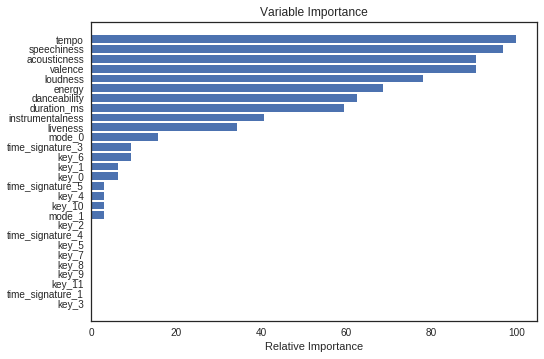

In [18]:
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# #############################################################################
# Get best classifier

clf_best = clf.best_estimator_

# #############################################################################
# Plot feature importance
feature_importance = clf_best.feature_importances_
# make importances relative to max importance
print "Max feature importance: %f" % feature_importance.max()
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance).astype(int)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, genre_feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

<a id='gradient'></a>

### Gradient Boosting Classification
([return to top](#top))

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

In [ ]:
param_dist = {"max_depth": [5, 8],
              "max_features": "sqrt",
              "min_samples_split": sp_randint(175, 350),
              "min_samples_leaf": 25,
              "bootstrap": [True, False],
              "subsample": 0.8}


param_dist = {"max_depth": sp_randint(5, 9),
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(175, 350),
              "min_samples_leaf": sp_randint(15, 50),
              "bootstrap": [True, False],
              "subsample": np.random.uniform(0.7, 1.0)}

#### Tune learning rate & number of estimators.

In [58]:
# The scorers can be either be one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_parameters_`` and
# ``gs.best_index_``
gs = GridSearchCV(GradientBoostingClassifier(learning_rate=1.0, 
                                             min_samples_split=300,
                                             min_samples_leaf=30,
                                             max_depth=6,
                                             max_features='sqrt',
                                             subsample=0.8,
                                             random_state=42),
                  param_grid={'n_estimators': range(20, 101, 10)},
                  scoring='accuracy', cv=5)
gs.fit(X_train, y_train)
results = gs.cv_results_

In [59]:
results

{'mean_fit_time': array([1.97, 2.9 , 3.84, 4.78, 5.7 , 6.71, 7.37, 8.21, 9.05]),
 'mean_score_time': array([0.02, 0.03, 0.03, 0.04, 0.05, 0.05, 0.06, 0.07, 0.07]),
 'mean_test_score': array([0.77, 0.8 , 0.83, 0.84, 0.84, 0.84, 0.83, 0.82, 0.8 ]),
 'mean_train_score': array([0.85, 0.89, 0.92, 0.94, 0.94, 0.94, 0.93, 0.92, 0.89]),
 'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80, 90, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 20},
  {'n_estimators': 30},
  {'n_estimators': 40},
  {'n_estimators': 50},
  {'n_estimators': 60},
  {'n_estimators': 70},
  {'n_estimators': 80},
  {'n_estimators': 90},
  {'n_estimators': 100}],
 'rank_test_score': array([9, 7, 5, 3, 2, 1, 4, 6, 8], dtype=int32),
 'split0_test_score': array([0.77, 0.8 , 0.82, 0.84, 0.83, 0.82, 0.81, 0.8 , 0.75]),
 'split0_train_score': array([0.84, 0.89, 0.92, 0.9

In [61]:
gs.grid_scores_, gs.best_params_, gs.best_score_

/home/austin/tensorflow/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.77350, std: 0.00390, params: {'n_estimators': 20},
  mean: 0.80439, std: 0.00350, params: {'n_estimators': 30},
  mean: 0.82589, std: 0.00357, params: {'n_estimators': 40},
  mean: 0.83644, std: 0.00795, params: {'n_estimators': 50},
  mean: 0.84116, std: 0.01618, params: {'n_estimators': 60},
  mean: 0.84161, std: 0.02367, params: {'n_estimators': 70},
  mean: 0.83265, std: 0.03113, params: {'n_estimators': 80},
  mean: 0.81904, std: 0.03781, params: {'n_estimators': 90},
  mean: 0.79981, std: 0.05218, params: {'n_estimators': 100}],
 {'n_estimators': 70},
 0.8416110419730739)

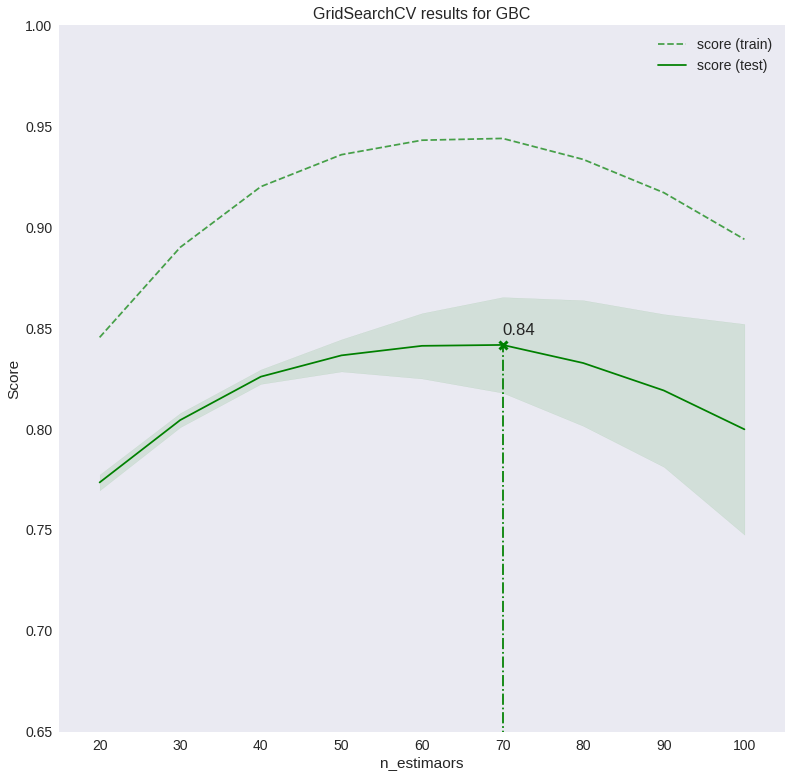

In [60]:
plt.figure(figsize=(7, 7))
plt.title("GridSearchCV results for GBC",
          fontsize=16)

plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(15, 105)
ax.set_ylim(0.65, 1.0)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_estimators'].data, dtype=float)

for scorer, color in zip(['score'], ['g']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()
plt.savefig('gbc_n_estimators.png', bbox_inches='tight')

Check feature importances on the best model so far.

In [ ]:
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# #############################################################################
# Get best classifier

clf_best = gs.best_estimator_

# #############################################################################
# Plot feature importance
feature_importance = clf_best.feature_importances_
# make importances relative to max importance
print "Max feature importance: %f" % feature_importance.max()
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance).astype(int)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, genre_feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Alternate feature importances:

In [ ]:
feat_imp = pd.Series(gs.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### Tune tree parameters.

In [62]:
param_test2 = {'max_depth':range(4,15,2), 'min_samples_split':range(100,801,100)}
gsearch2 = GridSearchCV(GradientBoostingClassifier(learning_rate=1.0,
                                                   n_estimators=70,
                                                     min_samples_leaf=30,
                                                     max_features='sqrt',
                                                     subsample=0.8,
                                                     random_state=42),
                          param_grid=param_test2,
                          scoring='accuracy', cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

/home/austin/tensorflow/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.80029, std: 0.00800, params: {'min_samples_split': 100, 'max_depth': 4},
  mean: 0.78507, std: 0.02861, params: {'min_samples_split': 200, 'max_depth': 4},
  mean: 0.79424, std: 0.00526, params: {'min_samples_split': 300, 'max_depth': 4},
  mean: 0.77184, std: 0.01653, params: {'min_samples_split': 400, 'max_depth': 4},
  mean: 0.78422, std: 0.00879, params: {'min_samples_split': 500, 'max_depth': 4},
  mean: 0.77520, std: 0.01515, params: {'min_samples_split': 600, 'max_depth': 4},
  mean: 0.77868, std: 0.00922, params: {'min_samples_split': 700, 'max_depth': 4},
  mean: 0.77698, std: 0.01026, params: {'min_samples_split': 800, 'max_depth': 4},
  mean: 0.87892, std: 0.00435, params: {'min_samples_split': 100, 'max_depth': 6},
  mean: 0.85386, std: 0.04026, params: {'min_samples_split': 200, 'max_depth': 6},
  mean: 0.84161, std: 0.02367, params: {'min_samples_split': 300, 'max_depth': 6},
  mean: 0.83443, std: 0.03621, params: {'min_samples_split': 400, 'max_depth': 6},
  me

In [63]:
param_test2 = {'max_depth':range(5,8,1), 'min_samples_split':range(100,801,100)}
gsearch2 = GridSearchCV(GradientBoostingClassifier(learning_rate=1.0,
                                                   n_estimators=70,
                                                     min_samples_leaf=30,
                                                     max_features='sqrt',
                                                     subsample=0.8,
                                                     random_state=42),
                          param_grid=param_test2,
                          scoring='accuracy', cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

/home/austin/tensorflow/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83892, std: 0.01541, params: {'min_samples_split': 100, 'max_depth': 5},
  mean: 0.79647, std: 0.03733, params: {'min_samples_split': 200, 'max_depth': 5},
  mean: 0.81251, std: 0.03219, params: {'min_samples_split': 300, 'max_depth': 5},
  mean: 0.81443, std: 0.03046, params: {'min_samples_split': 400, 'max_depth': 5},
  mean: 0.81039, std: 0.03213, params: {'min_samples_split': 500, 'max_depth': 5},
  mean: 0.79576, std: 0.02929, params: {'min_samples_split': 600, 'max_depth': 5},
  mean: 0.80807, std: 0.01212, params: {'min_samples_split': 700, 'max_depth': 5},
  mean: 0.81205, std: 0.00416, params: {'min_samples_split': 800, 'max_depth': 5},
  mean: 0.87892, std: 0.00435, params: {'min_samples_split': 100, 'max_depth': 6},
  mean: 0.85386, std: 0.04026, params: {'min_samples_split': 200, 'max_depth': 6},
  mean: 0.84161, std: 0.02367, params: {'min_samples_split': 300, 'max_depth': 6},
  mean: 0.83443, std: 0.03621, params: {'min_samples_split': 400, 'max_depth': 6},
  me

#### Tree params.

In [15]:
param_test3 = {'min_samples_split': [int(x) for x in np.logspace(1.4, 3.0, num=10)], 
               'min_samples_leaf': range(1, 71, 10)}
gsearch3 = GridSearchCV(GradientBoostingClassifier(learning_rate=1.0,
                                                   n_estimators=70,
                                                   max_depth=6,
                                                   max_features='sqrt',
                                                   subsample=0.8,
                                                   random_state=42),
                        param_grid=param_test3,
                        scoring='accuracy', cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

/home/austin/tensorflow/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83525, std: 0.01266, params: {'min_samples_split': 25, 'min_samples_leaf': 1},
  mean: 0.83180, std: 0.01378, params: {'min_samples_split': 37, 'min_samples_leaf': 1},
  mean: 0.82385, std: 0.01665, params: {'min_samples_split': 56, 'min_samples_leaf': 1},
  mean: 0.82586, std: 0.00974, params: {'min_samples_split': 85, 'min_samples_leaf': 1},
  mean: 0.82600, std: 0.01293, params: {'min_samples_split': 129, 'min_samples_leaf': 1},
  mean: 0.81997, std: 0.00828, params: {'min_samples_split': 194, 'min_samples_leaf': 1},
  mean: 0.83188, std: 0.01770, params: {'min_samples_split': 292, 'min_samples_leaf': 1},
  mean: 0.82393, std: 0.01824, params: {'min_samples_split': 441, 'min_samples_leaf': 1},
  mean: 0.79885, std: 0.03695, params: {'min_samples_split': 664, 'min_samples_leaf': 1},
  mean: 0.80368, std: 0.02646, params: {'min_samples_split': 1000, 'min_samples_leaf': 1},
  mean: 0.82818, std: 0.01787, params: {'min_samples_split': 25, 'min_samples_leaf': 11},
  mean: 0.812

Max feature importance: 0.119368


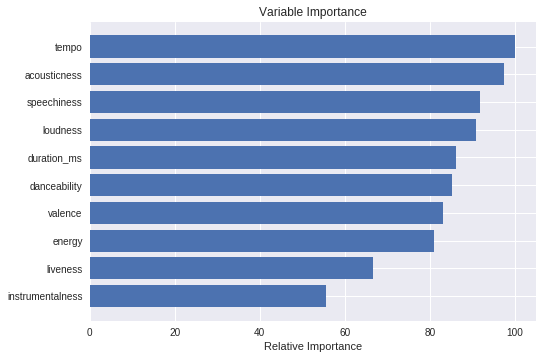

In [16]:
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# #############################################################################
# Get best classifier

clf_best = gsearch3.best_estimator_

# #############################################################################
# Plot feature importance
feature_importance = clf_best.feature_importances_
# make importances relative to max importance
print "Max feature importance: %f" % feature_importance.max()
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance).astype(int)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, genre_feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
plt.savefig('gbc_gs3_features.png', bbox_inches='tight')

Alternate feature importances:

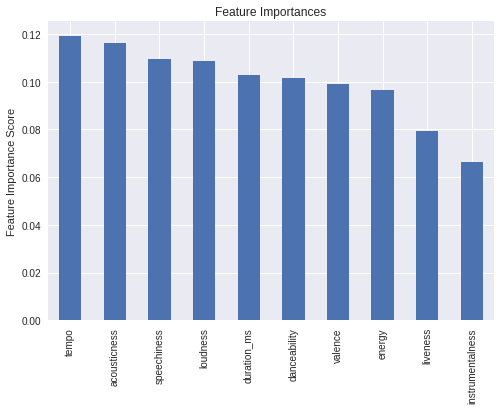

In [19]:
feat_imp = pd.Series(gsearch3.best_estimator_.feature_importances_, genre_feature_names).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
#{'min_samples_leaf': 21, 'min_samples_split': 199},
# 0.8606460006788098)

#{'min_samples_leaf': 61, 'min_samples_split': 129},
# 0.8760606403439303)

[1, 6, 11, 16, 21, 26, 31, 36]

In [82]:
map(int, np.logspace(1.4, 3.0, num=10))

[25, 37, 56, 85, 129, 194, 292, 441, 664, 1000]

In [ ]:
range(1, 41, 5)

In [77]:
map(int, np.logspace(0.0, 1.7, num=5))

[1, 2, 7, 18, 50]

#### Phase 4 - check max_features

In [44]:
param_test4 = {'max_features': range(1,11)}
gsearch4 = GridSearchCV(GradientBoostingClassifier(learning_rate=1.0, 
                                                   n_estimators=70,
                                                 min_samples_split=129,
                                                 min_samples_leaf=61,
                                                 max_depth=6,
                                                 subsample=0.8,
                                                 random_state=42),
                        param_grid=param_test4,
                        scoring='accuracy',
                        cv=5,
                        return_train_score=True)
gsearch4.fit(X_train, y_train)
results = gsearch4.cv_results_

In [45]:
results

{'mean_fit_time': array([ 5.14761696,  6.024682  ,  6.99362946,  7.97955384,  8.63960285,
         9.47262521, 10.33748498, 10.87953095, 12.00405025, 13.18773375]),
 'mean_score_time': array([0.06004744, 0.05915256, 0.05879655, 0.05808024, 0.05554934,
        0.05734563, 0.0569386 , 0.05509257, 0.05659876, 0.05663819]),
 'mean_test_score': array([0.83883924, 0.86573707, 0.87606064, 0.86404005, 0.85744994,
        0.88140627, 0.88194366, 0.86387035, 0.88081231, 0.87979409]),
 'mean_train_score': array([0.94753314, 0.9798903 , 0.9880289 , 0.97702613, 0.96149081,
        0.99310583, 0.99423011, 0.97139281, 0.99480288, 0.99483819]),
 'param_max_features': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_features': 1},
  {'max_features': 2},
  {'max_features': 3},
  {'max_features': 4},
  {'max_features': 5},
 

In [46]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

/home/austin/tensorflow/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83884, std: 0.03688, params: {'max_features': 1},
  mean: 0.86574, std: 0.00501, params: {'max_features': 2},
  mean: 0.87606, std: 0.00307, params: {'max_features': 3},
  mean: 0.86404, std: 0.02693, params: {'max_features': 4},
  mean: 0.85745, std: 0.04938, params: {'max_features': 5},
  mean: 0.88141, std: 0.00177, params: {'max_features': 6},
  mean: 0.88194, std: 0.00461, params: {'max_features': 7},
  mean: 0.86387, std: 0.03959, params: {'max_features': 8},
  mean: 0.88081, std: 0.00413, params: {'max_features': 9},
  mean: 0.87979, std: 0.00333, params: {'max_features': 10}],
 {'max_features': 7},
 0.8819436587849304)

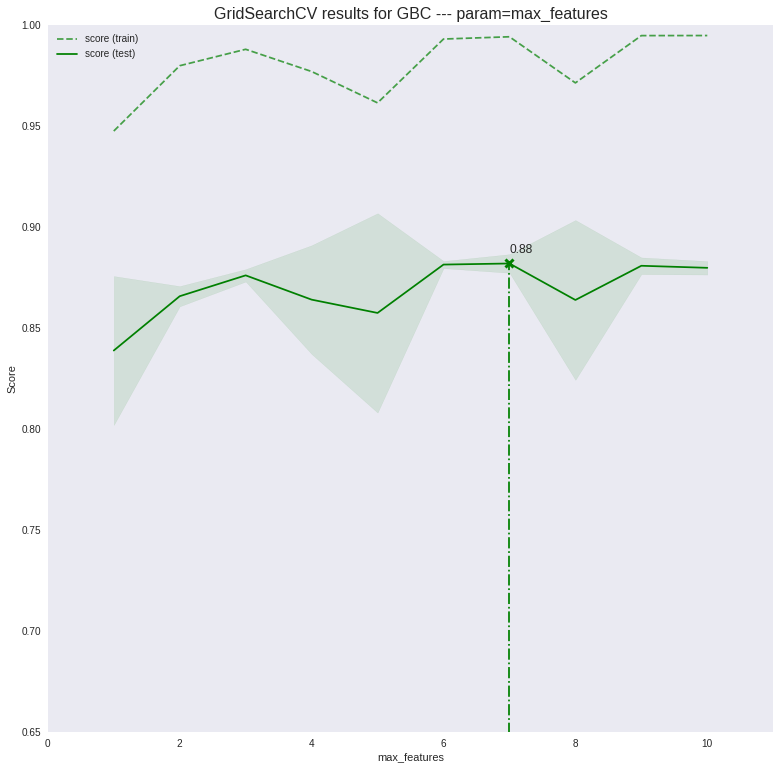

In [47]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV results for GBC --- param=max_features",
          fontsize=16)

plt.xlabel("max_features")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, 11)
ax.set_ylim(0.65, 1.0)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_max_features'].data, dtype=float)

for scorer, color in zip(['score'], ['g']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()
plt.savefig('gbc_max_features.png', bbox_inches='tight')

#### Phase 5 - Subsample

In [48]:
param_test5= {'subsample': np.linspace(0.6, 1.0, 9)}
gsearch5 = GridSearchCV(GradientBoostingClassifier(learning_rate=1.0, 
                                                   n_estimators=70,
                                                   min_samples_split=129,
                                                   min_samples_leaf=61,
                                                   max_depth=6,
                                                   max_features=7,
                                                   random_state=42),
                        param_grid=param_test5,
                        scoring='accuracy',
                        cv=5,
                        return_train_score=True)
gsearch5.fit(X_train, y_train)
results = gsearch5.cv_results_

In [49]:
results

{'mean_fit_time': array([ 9.57749505,  9.82617292, 10.09145083, 10.21253338, 10.58839421,
        10.62672219, 10.07055945, 10.64170046, 10.79141679]),
 'mean_score_time': array([0.05754943, 0.05753884, 0.05772319, 0.05621319, 0.05701103,
        0.05678983, 0.05294619, 0.05565977, 0.05568686]),
 'mean_test_score': array([0.86785836, 0.87320398, 0.87764453, 0.85911868, 0.88194366,
        0.88502659, 0.83125919, 0.88106686, 0.88646906]),
 'mean_train_score': array([0.98022971, 0.98512276, 0.99033402, 0.97165907, 0.99423011,
        0.99497256, 0.92878074, 0.99260411, 0.99687466]),
 'param_subsample': masked_array(data=[0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'subsample': 0.6},
  {'subsample': 0.65},
  {'subsample': 0.7},
  {'subsample': 0.75},
  {'subsample': 0.8},
  {'subsample': 0.85},
  {'subsample': 0.9},


In [50]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

/home/austin/tensorflow/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86786, std: 0.00396, params: {'subsample': 0.6},
  mean: 0.87320, std: 0.00573, params: {'subsample': 0.65},
  mean: 0.87764, std: 0.00364, params: {'subsample': 0.7},
  mean: 0.85912, std: 0.04134, params: {'subsample': 0.75},
  mean: 0.88194, std: 0.00461, params: {'subsample': 0.8},
  mean: 0.88503, std: 0.00214, params: {'subsample': 0.85},
  mean: 0.83126, std: 0.05345, params: {'subsample': 0.9},
  mean: 0.88107, std: 0.00938, params: {'subsample': 0.95},
  mean: 0.88647, std: 0.00269, params: {'subsample': 1.0}],
 {'subsample': 1.0},
 0.8864690575856997)

#### Phase 6 - LR, Model Count

In [54]:
clf = GradientBoostingClassifier(learning_rate=1.0, 
                                 n_estimators=70,
                                   min_samples_split=129,
                                   min_samples_leaf=61,
                                   max_depth=6,
                                   max_features=7,
                                   subsample=0.85,
                                   random_state=42)
cv_scores = sklearn.cross_validation.cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
## no measurement without standard deviation
# scores = computeTestScores(test_x=X_test, test_y=y_test, clf=grid_search.best_estimator_, cv=5)
print('CV scores:')
print('Mean: %f' % np.mean(cv_scores))
print('Stdev: %f' % np.std(cv_scores))

CV scores:
Mean: 0.868736
Stdev: 0.028417


In [55]:
clf = GradientBoostingClassifier(learning_rate=0.1, 
                                 n_estimators=700,
                                   min_samples_split=129,
                                   min_samples_leaf=61,
                                   max_depth=6,
                                   max_features=7,
                                   subsample=0.85,
                                   random_state=42)
cv_scores = sklearn.cross_validation.cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
## no measurement without standard deviation
# scores = computeTestScores(test_x=X_test, test_y=y_test, clf=grid_search.best_estimator_, cv=5)
print('CV scores:')
print('Mean: %f' % np.mean(cv_scores))
print('Stdev: %f' % np.std(cv_scores))

CV scores:
Mean: 0.904259
Stdev: 0.003770


In [56]:
clf = GradientBoostingClassifier(learning_rate=0.01, 
                                 n_estimators=7000,
                                   min_samples_split=129,
                                   min_samples_leaf=61,
                                   max_depth=6,
                                   max_features=7,
                                   subsample=0.85,
                                   random_state=42)
cv_scores = sklearn.cross_validation.cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
## no measurement without standard deviation
# scores = computeTestScores(test_x=X_test, test_y=y_test, clf=grid_search.best_estimator_, cv=5)
print('CV scores:')
print('Mean: %f' % np.mean(cv_scores))
print('Stdev: %f' % np.std(cv_scores))

CV scores:
Mean: 0.905674
Stdev: 0.004041


In [15]:
clf = GradientBoostingClassifier(learning_rate=0.01, 
                                 n_estimators=7000,
                                   min_samples_split=129,
                                   min_samples_leaf=61,
                                   max_depth=6,
                                   max_features=3,
                                   subsample=0.85,
                                   random_state=42)
cv_scores = sklearn.cross_validation.cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
## no measurement without standard deviation
# scores = computeTestScores(test_x=X_test, test_y=y_test, clf=grid_search.best_estimator_, cv=5)
print('CV scores:')
print('Mean: %f' % np.mean(cv_scores))
print('Stdev: %f' % np.std(cv_scores))

CV scores:
Mean: 0.905504
Stdev: 0.003604


<a id='gbc_summary'></a>

## GBC Summary - Best Model
([return to top](#top))

#### Finalize and test best model!

In [15]:
clf = GradientBoostingClassifier(learning_rate=0.01, 
                                 n_estimators=7000,
                                   min_samples_split=129,
                                   min_samples_leaf=61,
                                   max_depth=6,
                                   max_features=7,
                                   subsample=0.85,
                                   random_state=42)

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# best = GradientBoostingClassifier(learning_rate=0.1, n_estimators=250, min_samples_split=500, 
#                                    min_samples_leaf=50, max_depth=8, 
#                                    max_features='sqrt', subsample=0.8, 
#                                    random_state=10)

best = GradientBoostingClassifier(learning_rate=0.01, 
                                  n_estimators=7000,
                                    min_samples_split=129,
                                    min_samples_leaf=61,
                                    max_depth=6,
                                    max_features=7,
                                    subsample=0.85,
                                    random_state=42)


best.fit(X_train, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=6,
              max_features=7, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=61, min_samples_split=129,
              min_weight_fraction_leaf=0.0, n_estimators=7000,
              presort='auto', random_state=42, subsample=0.85, verbose=0,
              warm_start=False)

In [26]:
score_train = best.score(X_train, y_train)
score_test = best.score(X_test, y_test)

print("------------")
print("training data score: ", best.score(X_train,y_train))
print("test data score: ", best.score(X_test,y_test))
print("------------")

results_df.loc[results_df['classifier'] == 'gbc'] = ['gbc', score_train, score_test]

------------
training data score:  0.9975675981445865
test data score:  0.9134639857470094
------------


In [27]:
y_pred = best.fit(X_train, y_train).predict(X_test)

In [45]:
from sklearn.metrics import classification_report

print('Classification report:')
print(classification_report(y_test, y_pred, digits=3))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

Classification report:
             precision    recall  f1-score   support

          0      0.858     0.872     0.865       783
          1      0.983     1.000     0.992       772
          2      0.875     0.931     0.902       823
          3      0.889     0.759     0.819       752
          4      0.959     0.997     0.978       799

avg / total      0.913     0.913     0.912      3929

Confusion matrix:
[[683   3  30  49  18]
 [  0 772   0   0   0]
 [ 30   4 766  22   1]
 [ 81   6  79 571  15]
 [  2   0   0   0 797]]


In [35]:
# columns = ['train_acc', 'test_acc', 'p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'r_0', 'r_1', 'r_2', 'r_3', 'r_4', 'f']

results_df.loc['gbc'] = [0.9975675981445865,
                         0.9134639857470094,
                         0.858,
                         0.983,
                         0.875,
                         0.889,
                         0.959,
                         0.872,
                         1.000,
                         0.931,
                         0.759,
                         0.997,
                         0.912]
results_df.head()

,train_acc,test_acc,p_0,p_1,p_2,p_3,p_4,r_0,r_1,r_2,r_3,r_4,f
knn,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
abc,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
gbc,0.997568,0.913464,0.858,0.983,0.875,0.889,0.959,0.872,1.0,0.931,0.759,0.997,0.912
svc,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
rfc,0.999972,0.923390,0.846,0.976,0.915,0.872,0.973,0.872,1.0,0.926,0.787,0.997,0.917


In [28]:
from sklearn.metrics import confusion_matrix

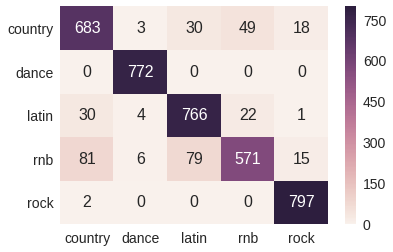

In [29]:
cnf_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cnf_matrix, index = [i for i in genre_list],
                     columns = [i for i in genre_list])
plt.figure(figsize=(6,4))
sns.set(font_scale=1.4)                                           # label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')   # font size
plt.savefig('gbc_best_confusion_A.png', bbox_inches='tight')

Confusion matrix, without normalization
[[683   3  30  49  18]
 [  0 772   0   0   0]
 [ 30   4 766  22   1]
 [ 81   6  79 571  15]
 [  2   0   0   0 797]]
Normalized confusion matrix
[[0.87 0.   0.04 0.06 0.02]
 [0.   1.   0.   0.   0.  ]
 [0.04 0.   0.93 0.03 0.  ]
 [0.11 0.01 0.11 0.76 0.02]
 [0.   0.   0.   0.   1.  ]]


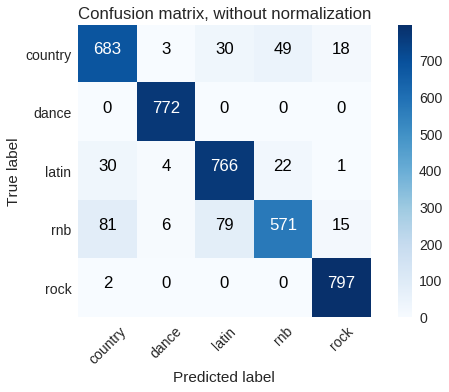

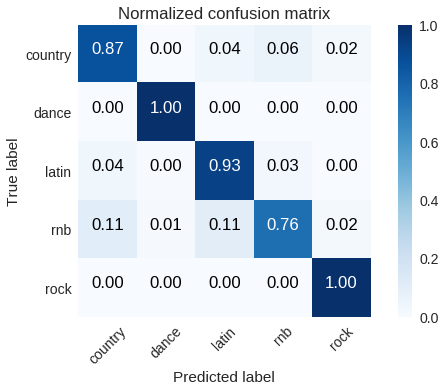

In [32]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=genre_list,
                      title='Confusion matrix, without normalization')
plt.grid('off')
plt.savefig('gbc_best_confusion_B.png', bbox_inches='tight')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=genre_list, normalize=True,
                      title='Normalized confusion matrix')
plt.grid('off')
plt.savefig('gbc_best_confusion_C.png', bbox_inches='tight')

### Feature Importances for Best Classifier

Max feature importance: 0.128890


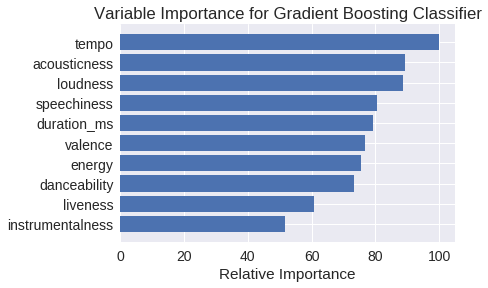

In [38]:
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error


# #############################################################################
# Plot feature importance
feature_importance = best.feature_importances_
# make importances relative to max importance
print "Max feature importance: %f" % feature_importance.max()
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance).astype(int)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(6,4))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, genre_feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance for Gradient Boosting Classifier')
plt.show()
plt.savefig('gbc_gs3_features_A.png', bbox_inches='tight')

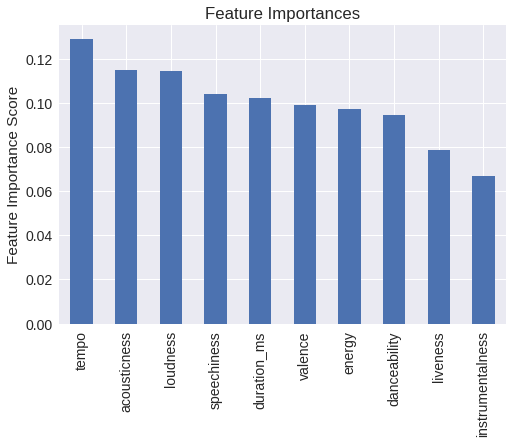

In [36]:
feat_imp = pd.Series(best.feature_importances_, genre_feature_names).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.savefig('gbc_gs3_features_B.png', bbox_inches='tight')

#### Precision/recall:

In [45]:
from sklearn.metrics import classification_report

print('Classification report:')
print(classification_report(y_test, y_pred, digits=3))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

Classification report:
             precision    recall  f1-score   support

          0      0.858     0.872     0.865       783
          1      0.983     1.000     0.992       772
          2      0.875     0.931     0.902       823
          3      0.889     0.759     0.819       752
          4      0.959     0.997     0.978       799

avg / total      0.913     0.913     0.912      3929

Confusion matrix:
[[683   3  30  49  18]
 [  0 772   0   0   0]
 [ 30   4 766  22   1]
 [ 81   6  79 571  15]
 [  2   0   0   0 797]]


In [ ]:
# (learning_rate=0.1, 
# n_estimators=70,
# min_samples_split=129,
# min_samples_leaf=61,
# max_depth=6,
# max_features=3,
# subsample=1.0,
# random_state=42)

# Test Scores:
# Mean: 0.890372
# Stdev: 0.002087

#### Random and grid searches.

In [ ]:
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

#### Old attempts:

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                 max_depth=1, random_state=0)
lr_s = np.linspace(0.2, 2.0, 8)

scores = list()
scores_std = list()
for lr in lr_s:
    clf.learning_rate = lr
    this_scores = cross_val_score(clf, X_train, y_train, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

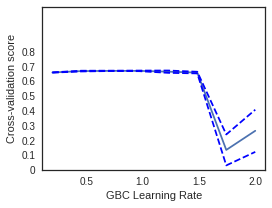

In [16]:
# Do the plotting
import matplotlib.pyplot as plt
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.plot(lr_s, scores)
plt.plot(lr_s, np.array(scores) + np.array(scores_std), 'b--')
plt.plot(lr_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('Cross-validation score')
plt.xlabel('GBC Learning Rate')
plt.ylim(0, 1.1)
plt.show()

#### Grid search (GBC)

In [17]:
#Choose all predictors except target & IDcols

X_values = X.values

param_test1 = {'n_estimators': range(60, 120, 6), 'learning_rate': np.linspace(0.05, 0.25, 5)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500, 
                                                               min_samples_leaf=50, max_depth=8, 
                                                               max_features='sqrt', subsample=0.8, 
                                                               random_state=10), 
                        param_grid = param_test1, iid=False, cv=5)
gsearch1.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=50,
              min_samples_split=500, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'n_estimators': [60, 66, 72, 78, 84, 90, 96, 102, 108, 114], 'learning_rate': array([ 0.05,  0.1 ,  0.15,  0.2 ,  0.25])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [18]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 4.18618135,  4.71627498,  4.93031483,  5.4686337 ,  5.79322157,
          6.19864993,  6.81242318,  7.12003536,  7.40292273,  7.90003519,
          4.16093221,  4.55391722,  4.94298487,  5.32629213,  5.70816436,
          6.08393941,  6.45415921,  6.84337502,  7.20304489,  7.58929853,
          4.06909642,  4.44947557,  4.8200366 ,  5.18963842,  5.56872497,
          5.94946861,  6.31866164,  6.65258994,  6.90863924,  7.19283943,
          3.89482961,  4.23901076,  4.57868037,  4.92358503,  5.28387103,
          5.64060721,  6.03941298,  6.464679  ,  6.79310756,  7.17988806,
          3.83895864,  4.20828333,  4.60235343,  4.9653904 ,  5.32154546,
          5.70669742,  6.08700547,  6.455374  ,  6.91116576,  7.30097537]),
  'mean_score_time': array([ 0.03503442,  0.03840842,  0.04091597,  0.04427252,  0.04748101,
          0.05067182,  0.05493164,  0.05682445,  0.05914621,  0.06268282,
          0.03390698,  0.03709435,  0.04004974,  0.04318542,  0.04592357,


<a id='svc'></a>

## SVM (SVC)
([return to top](#top))

In [14]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
print param_grid

{'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]), 'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}


In [ ]:
print(__doc__)

import numpy as np

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score
from sklearn import svm

# build a classifier
clf = svm.SVC()


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# use a full grid over all parameters
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

Automatically created module for IPython interactive environment


#### More thorough hyperparameter search:

In [14]:
from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)


# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=3))
    print()



Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}

Grid scores on development set:

0.551 (+/-0.012) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.529 (+/-0.010) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.570 (+/-0.013) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.549 (+/-0.013) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.597 (+/-0.014) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
0.556 (+/-0.015) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
0.617 (+/-0.012) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
0.571 (+/-0.016) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}
0.556 (+/-0.018) for {'kernel': 'linear', 'C': 1}
0.556 (+/-0.018) for {'kernel': 'linear', 'C': 10}
0.556 (+/-0.018) for {'kernel': 'linear', 'C': 100}
0.555 (+/-0.019) for {'kernel': 'linear', 'C': 1000}

Detailed classification report:

The mode

In [15]:
from sklearn import svm

params = {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}

best = svm.SVC(**params)
best.fit(X_train, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
score_train = best.score(X_train, y_train)
score_test = best.score(X_test, y_test)

print("------------")
print("training data score: ", best.score(X_train,y_train))
print("test data score: ", best.score(X_test,y_test))
print("------------")

results_df.loc[results_df['classifier'] == 'svc'] = ['svc', score_train, score_test]

In [16]:
print "------------"
print "training data score: ", clf.score(X_train,y_train)
print "test data score: ", clf.score(X_test,y_test)
print "------------"

# old: 0.9467700, 0.8785951

------------
training data score:  0.618876569747709
test data score:  0.610333418172563
------------


In [17]:
y_pred = clf.fit(X_train, y_train).predict(X_test)

In [18]:
from sklearn.metrics import confusion_matrix

In [ ]:
f = plt.figure(figsize=(7,7))
plt.imshow(image[:,:,0], cmap='bone')
plt.title('True Class: [%s - %s] (ranked %d of 48) \nModel Prediction: [%s - %s]' % 
          (true_label, true_name, true_rank, predicted_label, predicted_name))
plt.axis('off')
plt.show()
f.savefig(solo_path, bbox_inches='tight')

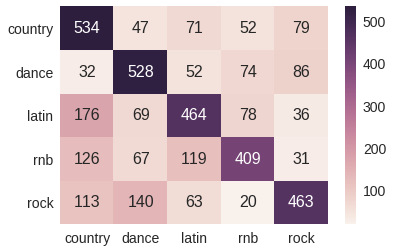

In [24]:
cnf_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cnf_matrix, index = [i for i in genre_list],
                     columns = [i for i in genre_list])
plt.figure(figsize = (6,4))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')# font size
plt.savefig('svc_confusion.png', bbox_inches='tight')

##### 7/26/17

Old attempt:

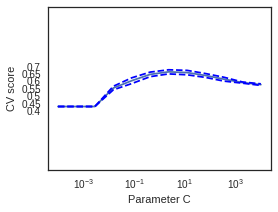

In [22]:
svc = svm.SVC()
C_s = np.logspace(-4, 4, 12)

scores = list()
scores_std = list()
for C in C_s:
    svc.C = C
    this_scores = cross_val_score(svc, X_scaled, y, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

# Do the plotting
import matplotlib.pyplot as plt
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0, 1.1)
plt.show()

<a id='misc'></a>

# Miscellaneous Tests
([return to top](#top))